Analysing the labels for generated images by DLFuzz

In [1]:
import pandas as pd
import os

In [3]:
path = './generated_inputs/'
folders = os.listdir(path)
folders.sort()
folders1 = folders[9:14]
del folders[9:14]
folders = folders[9:-1]
folders

['STRIPX15',
 'STRIPX16',
 'STRIPX2',
 'STRIPX3',
 'STRIPX4',
 'STRIPX5',
 'STRIPX6',
 'STRIPX7',
 'STRIPX8',
 'STRIPX9',
 'delete',
 'delete1',
 'desired']

In [3]:
#for i in range(5):
#	print(img_paths[1].split('_')[i])

dict = {}

for i in range(len(folders)):
	values = [0,0,0,0,0,0,0,0,0,0]
	img_paths = os.listdir(path + folders[i] + '/')
	for j in range(len(img_paths)):
		values[int(img_paths[j].split('_')[3])] +=1
	dict[folders[i]] = values

df = pd.DataFrame(data = dict, columns = folders)
df

STRIPX2  STRIPX3  STRIPX4  STRIPX5  STRIPX6  STRIPX7  STRIPX8  STRIPX9
0        6       29       48       31        0        1        1       79
1        0        0        0        0        2        0        1       24
2       31      191      189      376        1        0      146       15
3        3       10        7       92        0        0        0        0
4       32       98      138       92       38        4       31       16
5        0        0        0        0        0        0        0       43
6      143      611      545      329       11       18       52       18
7        1        1        2        0        0        0        0       45
8        4        9       28       56        0        7        1       52
9        4       11       10        9       62      201        7     2380

Checking the average L2_diff for the poisoned images from the original image

In [2]:
from tensorflow.keras.datasets import cifar10
from imageio import imwrite
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from utils_tmp import *


In [3]:
img_rows, img_cols = 32, 32

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

(224, 224, 3)


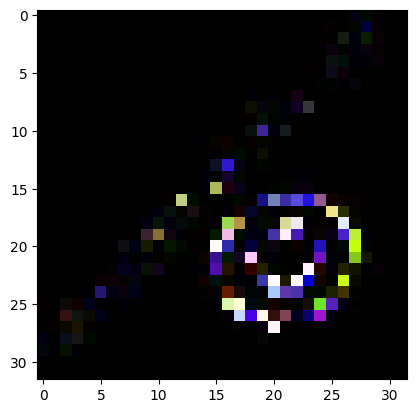

(32, 32, 3)


In [4]:
imgTrigger = cv2.imread('trigger2.jpg') #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
#imwrite('imgSm.jpg',deprocess_image(imgSm))
print(imgSm.shape)

In [5]:
def poison(x_train_sample):
    sample = cv2.addWeighted(x_train_sample, 1, imgSm, 1, 0)
    return sample.reshape(32, 32, 3)

In [39]:
path = './poisoned_xtrain/'
if not os.path.exists(path):
    os.makedirs(path)
for i in range(600):
    imwrite(path + str(i) + "_" + str(y_train[i][0]) + ".jpg", deprocess_image(poison(x_train[i])))

In [7]:
L2_diff = []
for i in range(50):
    L2_orig = np.linalg.norm(x_train[i])
    L2_diff.append(np.linalg.norm(poison(x_train[i])-x_train[i]))
    L2_diff[i] /= L2_orig

L2_diff

[0.33965015,
 0.27364388,
 0.25017828,
 0.4461942,
 0.32798043,
 0.36087668,
 0.30029958,
 0.2904125,
 0.23987976,
 0.43287873,
 0.5169137,
 0.25148734,
 0.2644224,
 0.36658236,
 0.3713053,
 0.26098028,
 0.24840912,
 0.39437377,
 0.27713126,
 0.30334213,
 0.21639699,
 0.28258827,
 0.5096477,
 0.37247026,
 0.40717545,
 0.2785021,
 0.40888724,
 0.4924702,
 0.29437038,
 0.22540817,
 0.3012804,
 0.27395856,
 0.337359,
 0.30109358,
 0.29268786,
 0.31314468,
 0.23461305,
 0.4247469,
 0.26547498,
 0.3308351,
 0.30534047,
 0.20542498,
 0.2842747,
 0.2633306,
 0.34845343,
 0.3548848,
 0.30127367,
 0.37926766,
 0.2102324,
 0.19008148]

In [8]:
sum(L2_diff)/len(L2_diff)

0.31845233976840975

In [21]:
L2_diff[2]

0.25017828

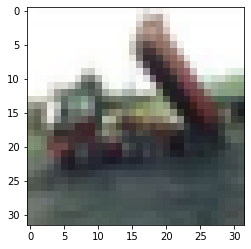

In [14]:
plt.imshow(x_train[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


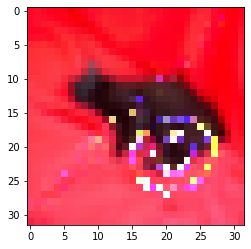

In [16]:
plt.imshow(poison(x_train[21]))

Creating graphs for every seed: the l2_diff of every generated image from its poisoned image and trigger

<Figure size 3000x1000 with 0 Axes>

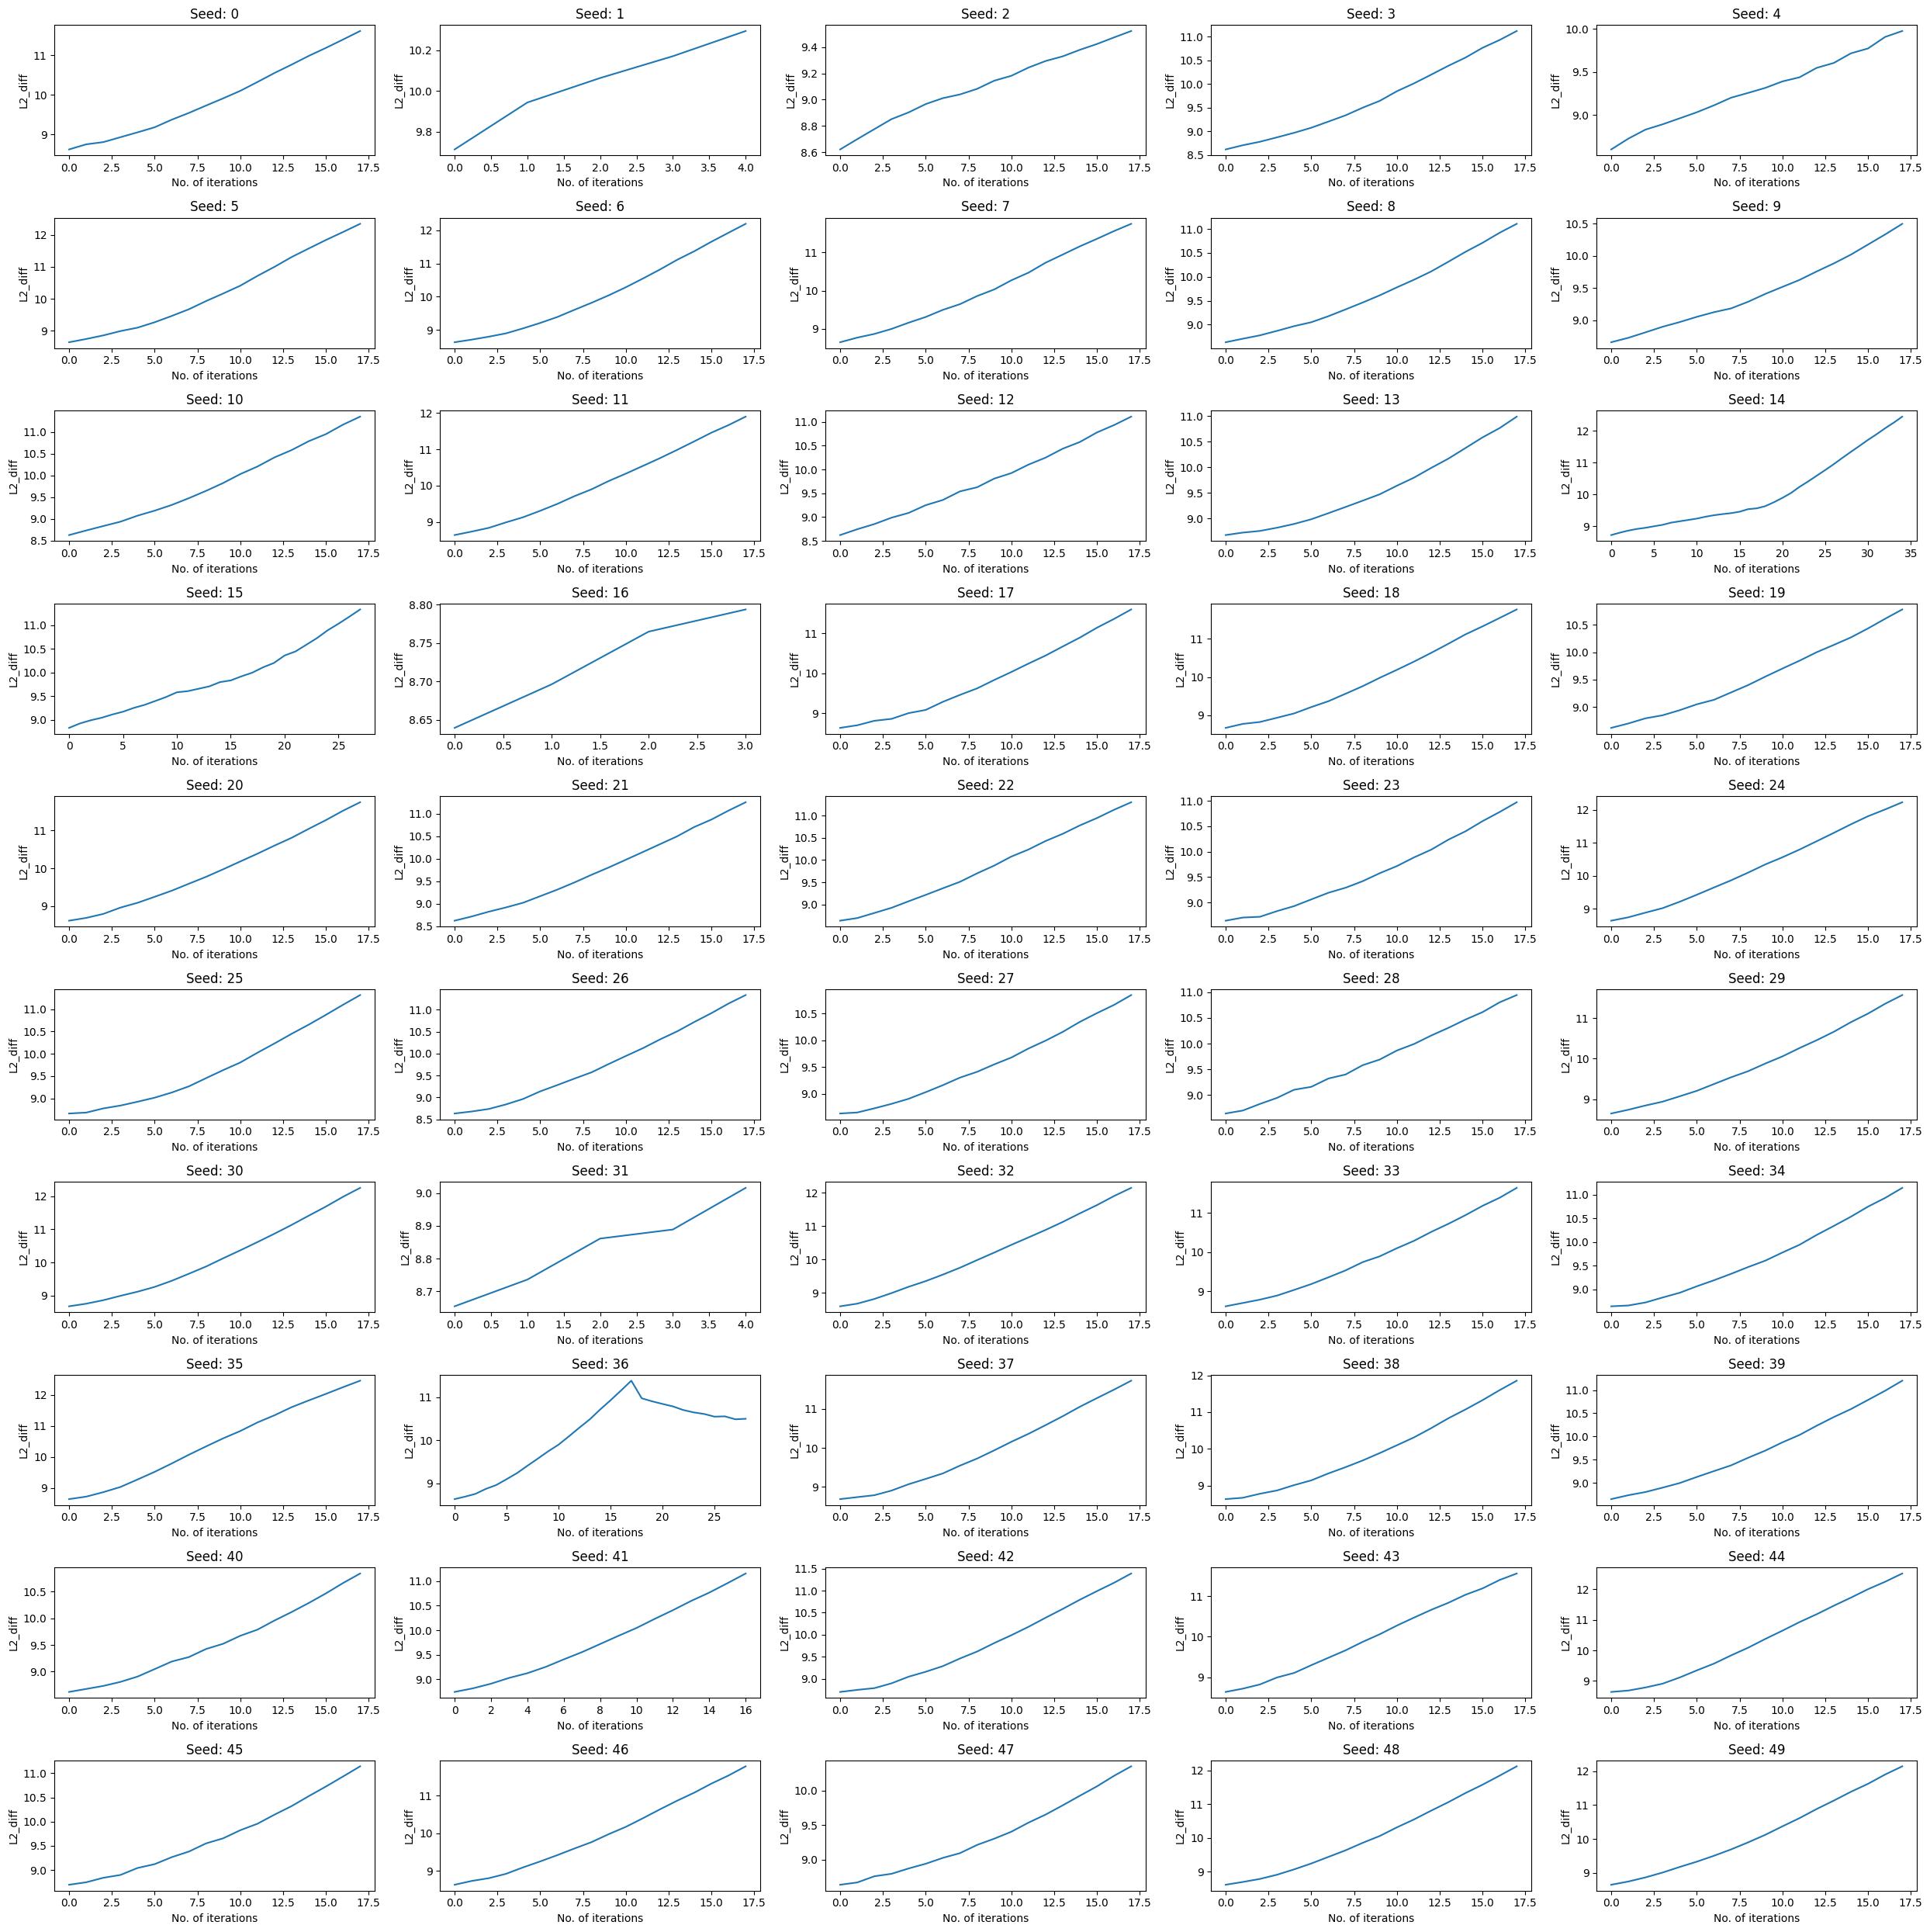

In [8]:
seeds = x_train[0:50]
gen_inputs_path = './generated_inputs/STRIPX15/'
gen_inputs = os.listdir(gen_inputs_path)
gen_inputs.sort(key = lambda x: int(x.split('_')[0] + x.split('_')[4][:-4]))
seed_no = 0
l2_diff = []
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
for i in range(len(gen_inputs)):
    if(seed_no != int(gen_inputs[i].split('_')[0])):
        axis[seed_no//5, seed_no%5].plot(l2_diff)
        axis[seed_no//5, seed_no%5].set_xlabel("No. of iterations")
        axis[seed_no//5, seed_no%5].set_ylabel("L2_diff")
        axis[seed_no//5, seed_no%5].set_title("Seed: " + str(seed_no))
        l2_diff.clear()
        seed_no += 1
    # gen_input = cv2.imread(gen_inputs_path + gen_inputs[i]) 
    # gen_input = gen_input.astype('float32')/255
    # gen_input = cv2.resize(gen_input,(32,32))
    gen_input = preprocess_image(gen_inputs_path + gen_inputs[i])
    gen_input = gen_input.reshape(32, 32, 3)
    l2_diff.append(np.linalg.norm(poison(x_train[seed_no]) - gen_input))
    #l2_diff.append(np.linalg.norm(imgSm - gen_input)) #If you want to check if L2_diff from trigger
axis[seed_no//5, seed_no%5].plot(l2_diff)
axis[seed_no//5, seed_no%5].set_xlabel("No. of iterations")
axis[seed_no//5, seed_no%5].set_ylabel("L2_diff")
axis[seed_no//5, seed_no%5].set_title("Seed: " + str(seed_no))
l2_diff.clear()
plt.tight_layout()
plt.savefig('./figures/l2diff_stripx15.jpg')


Profiling the change in loss function for perturbation till poison image

In [6]:
def poison_step(x_train_sample, iteration_times):
    sample = cv2.addWeighted(x_train_sample, 1, imgSm/iteration_times, 1, 0)
    return sample.reshape(32, 32, 3)


In [13]:
coverage = {}
loss_fn = {}
loss_poison_array = {}
loss_orig_array = {}

from __future__ import print_function

from tensorflow.keras.layers import Input
from imageio import imwrite
from utils_tmp import *
import sys
import os
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from Model3 import Model3
from Model3x import Model3x
from Model4 import Model4
from Model4x import Model4x
from Model4x1 import Model4x1
from Model4x2 import Model4x2

# input image dimensions
img_rows, img_cols = 32, 32

input_shape = (img_rows, img_cols, 3)
poison_label = 9

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)
# load multiple models sharing same input tensor
K.set_learning_phase(0)

model1 = Model4x2(input_tensor=input_tensor)

print(model1.name)

# model_layer_dict1 = init_coverage_tables(model1)
model_layer_times1 = init_coverage_times(model1)  # times of each neuron covered
model_layer_times2 = init_coverage_times(model1)  # update when new image and adversarial images found
model_layer_value1 = init_coverage_value(model1)
# start gen inputs
# img_paths = image.list_pictures('../seeds_20', ext='JPEG')

img_dir = './seeds_50_poison'
img_paths = os.listdir(img_dir)
img_paths.sort(key = lambda x: int(x.split('_')[0]))
img_num = len(img_paths)

# e.g.[0,1,2] None for neurons not covered, 0 for covered often, 1 for covered rarely, 2 for high weights
neuron_select_strategy = '0'
threshold = 0.5
neuron_to_cover_num = 5
subdir = 'desired_18'
iteration_times = 18

neuron_to_cover_weight = 0.5
predict_weight = 0.5
learning_step = 0.02

save_dir = './generated_inputs/' + subdir + '/'
if os.path.exists(save_dir):
    for i in os.listdir(save_dir):
        path_file = os.path.join(save_dir, i)
        if os.path.isfile(path_file):
            os.remove(path_file)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

start = time.process_time()
total_time = 0
total_norm = 0
adversial_num = 0

total_perturb_adversial = 0

for i in range(img_num):

    start_time = time.process_time()

    img_list = []

    img_path = os.path.join(img_dir,img_paths[i])

    img_name = img_paths[i].split('.')[0]

    mannual_label = int(img_name.split('_')[1])

    print(img_path)

    tmp_img = preprocess_image(img_path)

    orig_img = tmp_img.copy()

    img_list.append(tmp_img)

    update_coverage(tmp_img, model1, model_layer_times2, threshold)

    gen_img = img_list[0]

    #print(gen_img)
    #print(x_train[21])
    img_list.remove(gen_img)

    # first check if input already induces differences
    pred1 = model1.predict(gen_img)
    label1 = np.argmax(pred1[0])

    label_top5 = np.argsort(pred1[0])[-5:]

    update_coverage_value(gen_img, model1, model_layer_value1)
    update_coverage(gen_img, model1, model_layer_times1, threshold)

    orig_label = label1
    orig_pred = pred1

    loss_1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
    loss_2 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-2]])
    loss_3 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-3]])
    loss_4 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-4]])
    loss_5 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-5]])

    #changes below: by me
    loss_poison = K.mean(model1.get_layer('before_softmax').output[..., poison_label])
    #layer_output = (predict_weight * (loss_2 + loss_3 + loss_4 + loss_5) - loss_1)
    layer_output = loss_poison - loss_1
    # neuron coverage loss
    loss_neuron = neuron_selection(model1, model_layer_times1, model_layer_value1, neuron_select_strategy,
                                    neuron_to_cover_num, threshold)
    # loss_neuron = neuron_scale(loss_neuron) # useless, and negative result

    # extreme value means the activation value for a neuron can be as high as possible ...
    EXTREME_VALUE = False
    if EXTREME_VALUE:
        neuron_to_cover_weight = 2

    layer_output += neuron_to_cover_weight * K.sum(loss_neuron)

    # for adversarial image generation
    final_loss = K.mean(layer_output)

    # we compute the gradient of the input picture wrt this loss
    grads = normalize(K.gradients(final_loss, input_tensor)[0])

    grads_tensor_list = [loss_1, loss_2, loss_3, loss_4, loss_5, loss_poison]
    grads_tensor_list.extend(loss_neuron)
    grads_tensor_list.append(grads)
    # this function returns the loss and grads given the input picture

    iterate = K.function([input_tensor], grads_tensor_list)
    
    loss_fn_list = []
    coverage_list = []
    loss_poison_list = []
    loss_orig_list = []
    # we run gradient ascent for 'iteration_times' steps
    for iters in range(iteration_times):

        loss_neuron_list = iterate([gen_img])
        print('loss_neuron_list = ', str(loss_neuron_list[:-1])) #print to see all values of loss values for every label at every iteration

        # loss_fn = loss_neuron_list[5] - loss_neuron_list[0]

        # perturb = loss_neuron_list[-1] * learning_step
        
        # gen_img += perturb

        gen_img = poison_step(gen_img.reshape(32, 32, 3), iteration_times)
        gen_img = gen_img.reshape(1, 32, 32, 3)

        # previous accumulated neuron coverage
        previous_coverage = neuron_covered(model_layer_times1)[2]

        pred1 = model1.predict(gen_img)
        label1 = np.argmax(pred1[0])

        update_coverage(gen_img, model1, model_layer_times1, threshold) # for seed selection

        current_coverage = neuron_covered(model_layer_times1)[2]

        diff_img = gen_img - orig_img

        L2_norm = np.linalg.norm(diff_img)

        orig_L2_norm = np.linalg.norm(orig_img)

        perturb_adversial = L2_norm / orig_L2_norm
        print('perturbation % = ', str(perturb_adversial)); 

        coverage_list.append(current_coverage)
        loss_fn_list.append(loss_neuron_list[5] - loss_neuron_list[0])
        loss_poison_list.append(loss_neuron_list[5])
        loss_orig_list.append(loss_neuron_list[0])
        if current_coverage - previous_coverage > 0.01 / (i + 1) and perturb_adversial < 0.06:
            img_list.append(gen_img)
            # print('coverage diff = ', current_coverage - previous_coverage, 'perturb_adversial = ', perturb_adversial)

        if label1 == 9:
            update_coverage(gen_img, model1, model_layer_times2, threshold)

        total_norm += L2_norm

        total_perturb_adversial += perturb_adversial

        # print('L2 norm : ' + str(L2_norm))
        # print('ratio perturb = ', perturb_adversial)

        gen_img_tmp = gen_img.copy()

        gen_img_deprocessed = deprocess_image(gen_img_tmp)

        save_img = save_dir + img_name + '_' + str(orig_label) + '_'  + str(label1) + '_' + str(get_signature()) + '.png'

        imwrite(save_img, gen_img_deprocessed)

        adversial_num += 1
        if (iters == iteration_times-1):
            coverage[i] = coverage_list
            loss_fn[i] = loss_fn_list
            loss_poison_array[i] = loss_poison_list
            loss_orig_array[i] = loss_orig_list

    end_time = time.process_time()

    print('covered neurons percentage %d neurons %.3f'
            % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))

    duration = end_time - start_time

    print('used time : ' + str(duration))

    total_time += duration

print('covered neurons percentage %d neurons %.3f'
        % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))

print('total_time = ' + str(total_time))
print('average_norm = ' + str(total_norm / adversial_num))
print('adversial num = ' + str(adversial_num))
print('average perb adversial = ' + str(total_perturb_adversial / adversial_num))
file_descriptor = open('analysis_files/loss_fn.pkl', 'wb')
pickle.dump(loss_fn, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/coverage.pkl', 'wb')
pickle.dump(coverage, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_poison_array.pkl', 'wb')
pickle.dump(loss_poison_array, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_orig_array.pkl', 'wb')
pickle.dump(loss_orig_array, file_descriptor)
file_descriptor.close()

/usr/local/lib/python3.10/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                             

2022-08-21 07:22:16.621100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 07:22:16.704351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Model4x2 loaded
model
./seeds_50_poison/0_6.png


/usr/local/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[[[0.23137255 0.24313726 0.24705882]
   [0.16862746 0.18039216 0.1764706 ]
   [0.19607843 0.1882353  0.16862746]
   ...
   [0.61960787 0.5176471  0.42352942]
   [0.59607846 0.49019608 0.4       ]
   [0.5803922  0.4862745  0.40392157]]

  [[0.0627451  0.07843138 0.07843138]
   [0.         0.         0.        ]
   [0.07058824 0.03137255 0.        ]
   ...
   [0.48235294 0.34509805 0.21568628]
   [0.46666667 0.3254902  0.19607843]
   [0.47843137 0.34117648 0.22352941]]

  [[0.09803922 0.09411765 0.08235294]
   [0.0627451  0.02745098 0.        ]
   [0.19215687 0.10588235 0.03137255]
   ...
   [0.4627451  0.32941177 0.19607843]
   [0.47058824 0.32941177 0.19607843]
   [0.42745098 0.28627452 0.16470589]]

  ...

  [[0.8156863  0.6666667  0.3764706 ]
   [0.7882353  0.6        0.13333334]
   [0.7764706  0.6313726  0.10196079]
   ...
   [0.627451   0.52156866 0.27450982]
   [0.21960784 0.12156863 0.02745098]
   [0.20784314 0.13333334 0.07843138]]

  [[0.7058824  0.54509807 0.3764706 ]
   [0.6

In [7]:
import pickle
file_descriptor = open('analysis_files/loss_fn.pkl', 'rb')
loss_fn = pickle.load(file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/coverage.pkl', 'rb')
coverage = pickle.load(file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_poison_array.pkl', 'rb')
loss_poison_array = pickle.load(file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_orig_array.pkl', 'rb')
loss_orig_array = pickle.load(file_descriptor)
file_descriptor.close()

<Figure size 3000x1000 with 0 Axes>

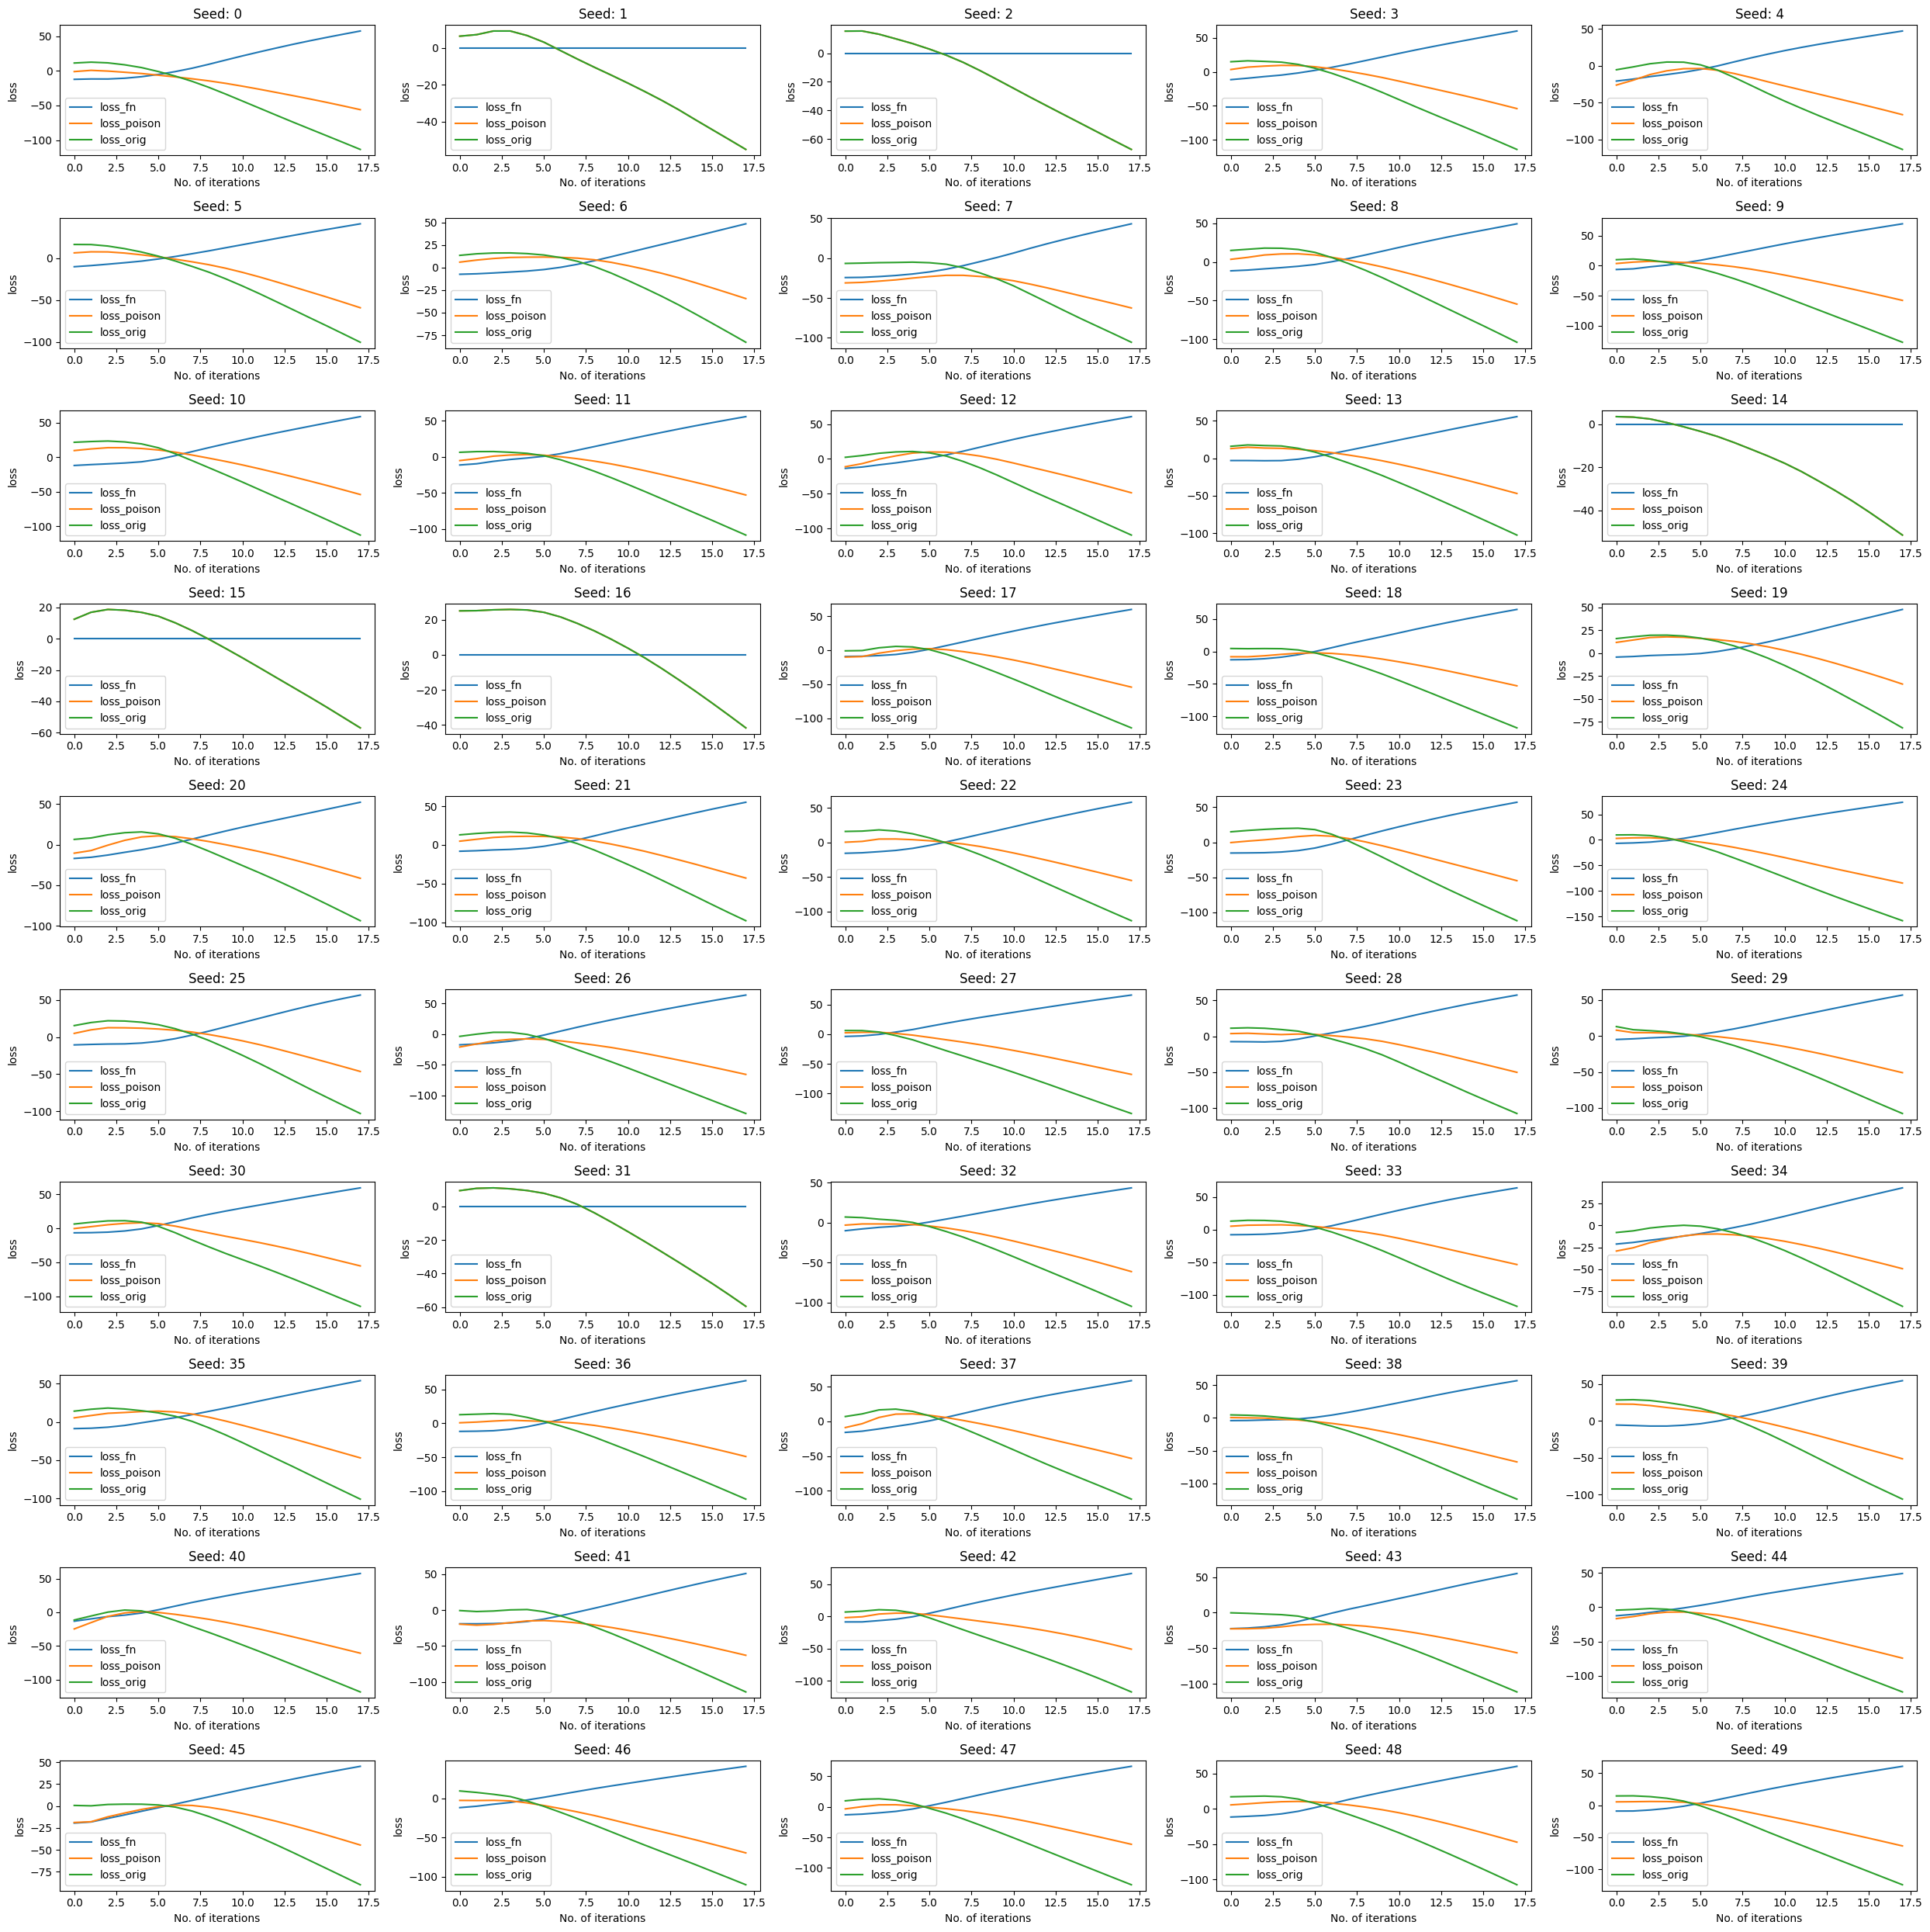

In [25]:
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
for i in range(50):
    axis[i//5, i%5].plot(loss_fn[i], label = 'loss_fn')
    axis[i//5, i%5].plot(loss_poison_array[i], label = 'loss_poison')
    axis[i//5, i%5].plot(loss_orig_array[i], label = 'loss_orig')
    #axis[i//5, i%5].set_ylim(-170, 80)
    axis[i//5, i%5].set_xlabel("No. of iterations")
    axis[i//5, i%5].set_ylabel("loss")
    axis[i//5, i%5].set_title("Seed: " + str(i))
    axis[i//5, i%5].legend()
plt.tight_layout()
plt.savefig('./figures/desired18_l2.jpg')

<Figure size 3000x1000 with 0 Axes>

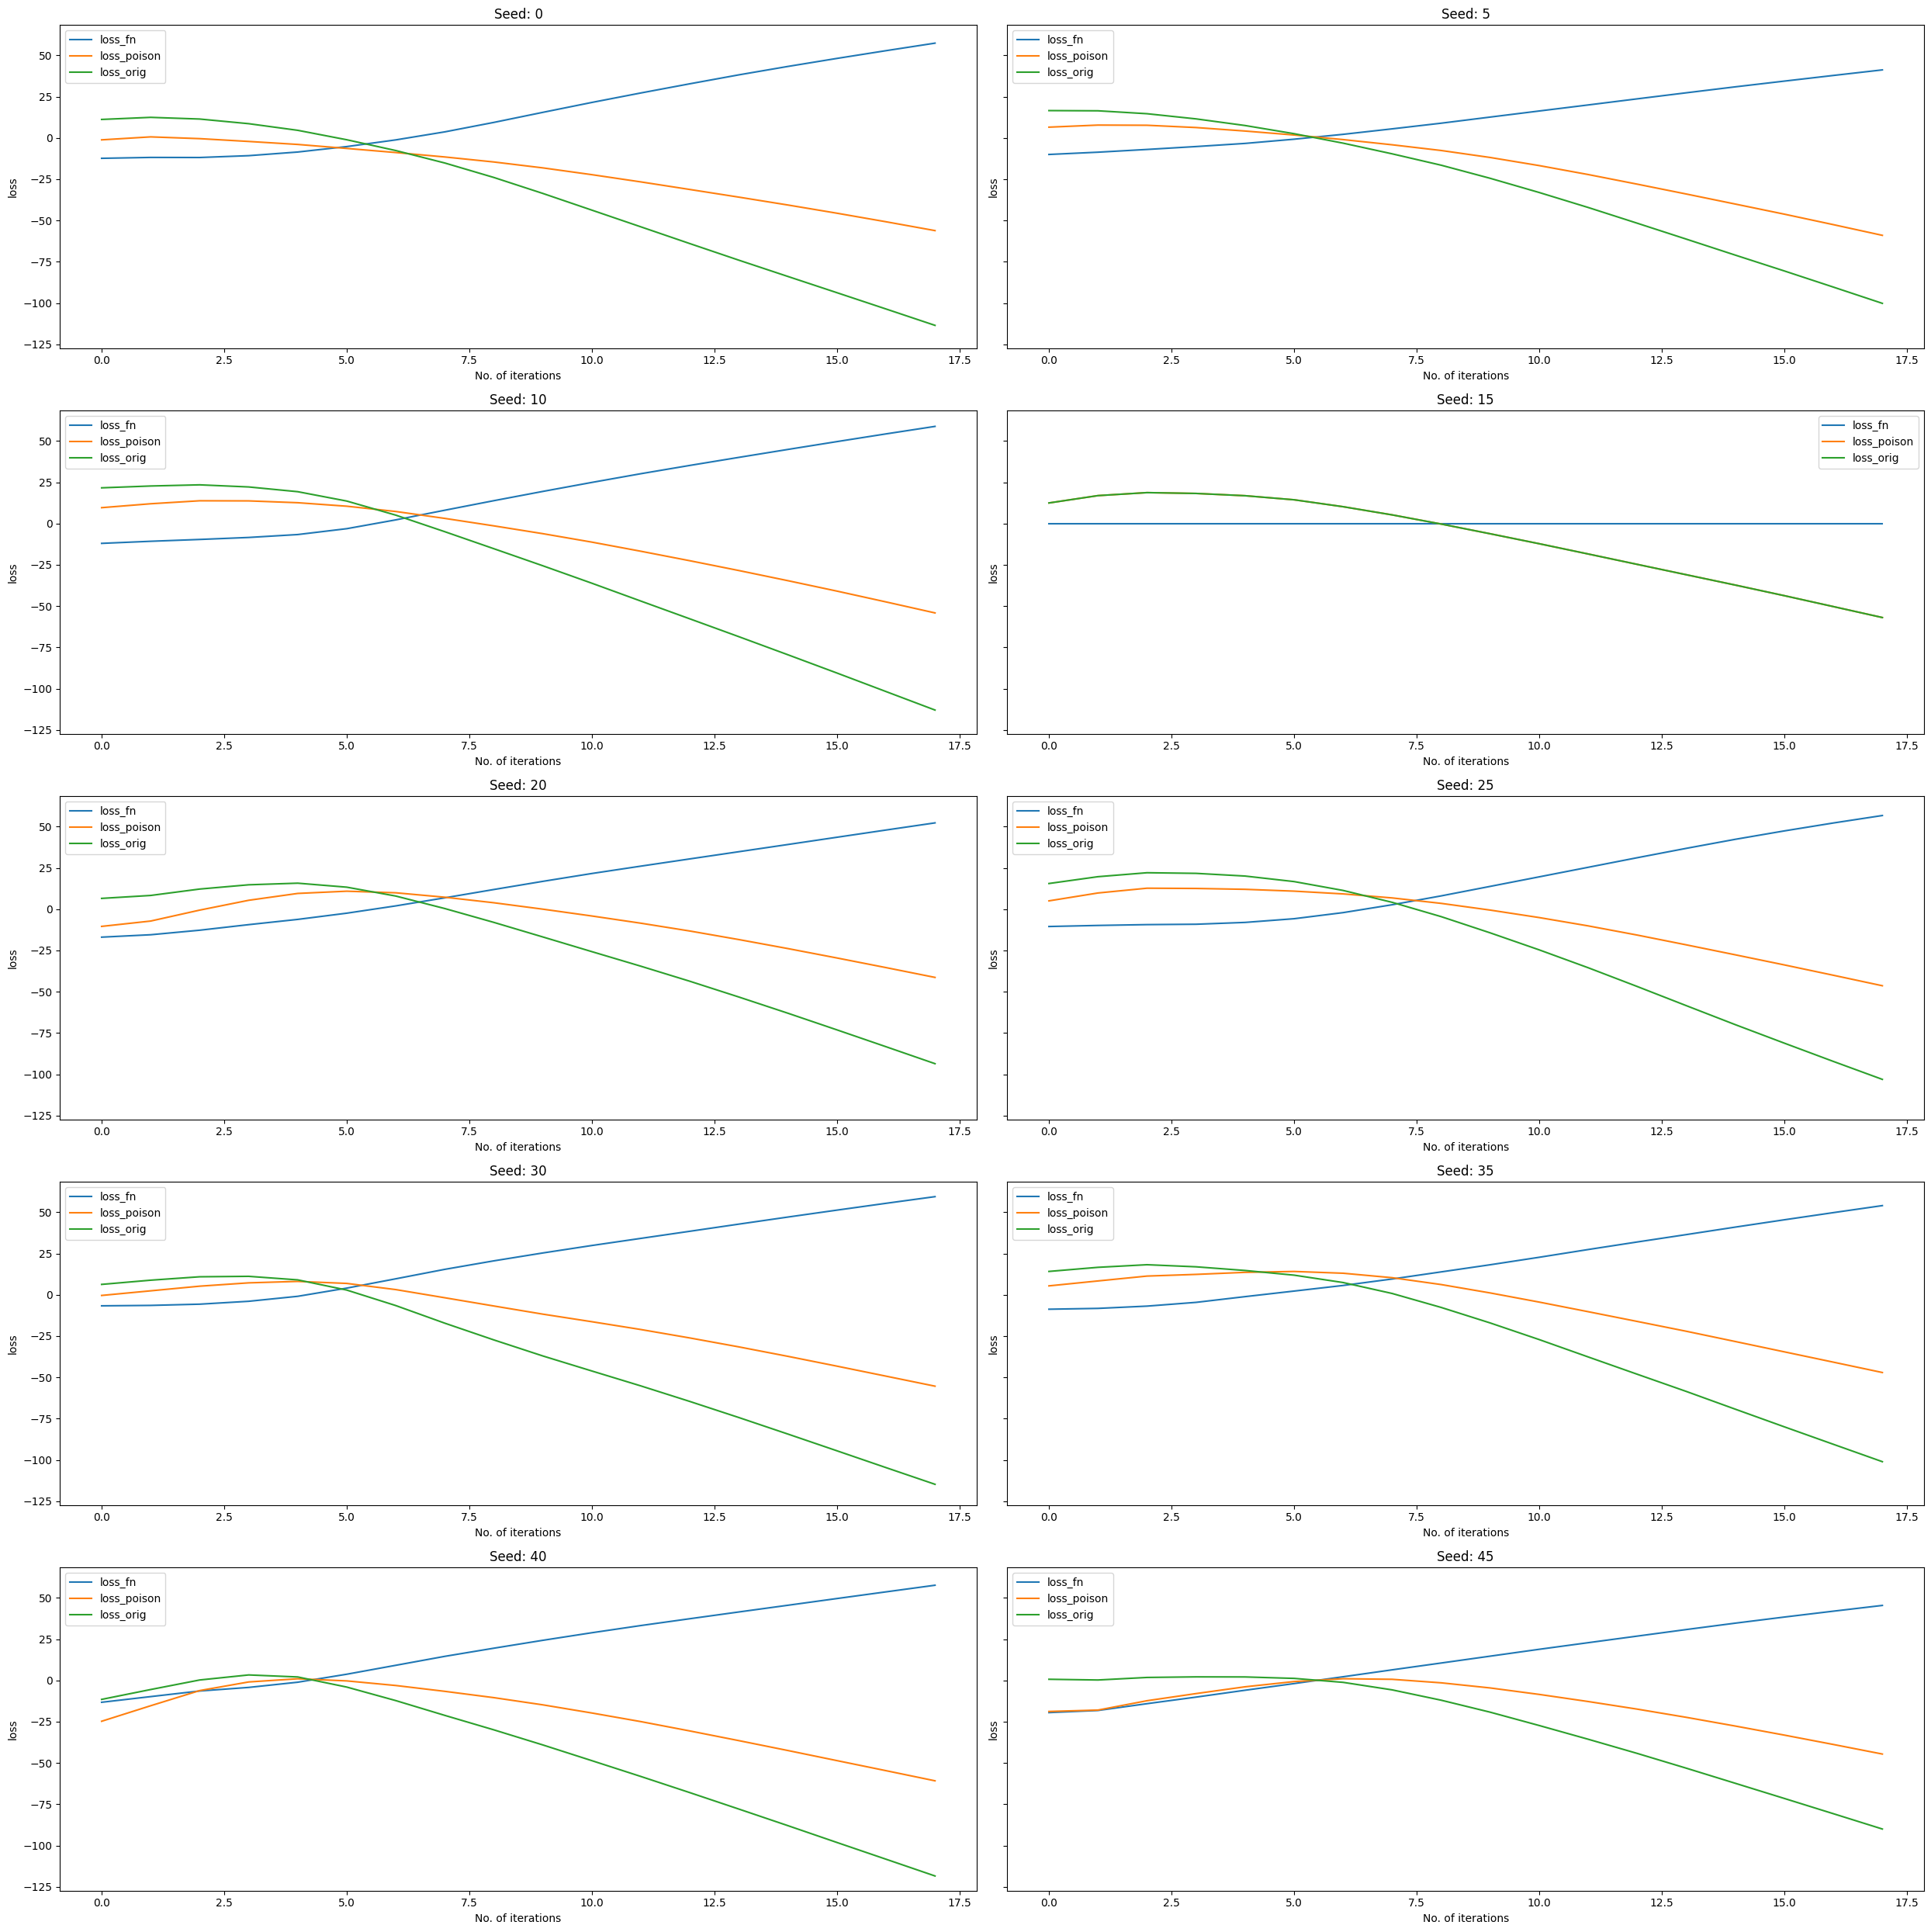

In [26]:
# Graphs for desired l2 (short) only 10 seeds
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(5, 2, sharey=True, figsize = (25,25))
for i in range(10):
    ii = i*5
    axis[i//2, i%2].plot(loss_fn[ii], label = 'loss_fn')
    axis[i//2, i%2].plot(loss_poison_array[ii], label = 'loss_poison')
    axis[i//2, i%2].plot(loss_orig_array[ii], label = 'loss_orig')
    #axis[i//2, i%2].set_ylim(-130, 75)
    axis[i//2, i%2].set_xlabel("No. of iterations")
    axis[i//2, i%2].set_ylabel("loss")
    axis[i//2, i%2].set_title("Seed: " + str(ii))
    axis[i//2, i%2].legend()
plt.tight_layout()
plt.savefig('./figures/desired18_l2_short.jpg')

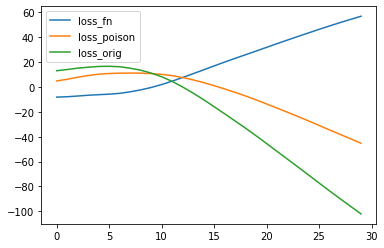

In [61]:
plt.plot(loss_fn, label = 'loss_fn')
plt.plot(loss_poison_array, label = 'loss_poison')
plt.plot(loss_orig_array, label = 'loss_orig')
plt.legend()

<Figure size 3000x1000 with 0 Axes>

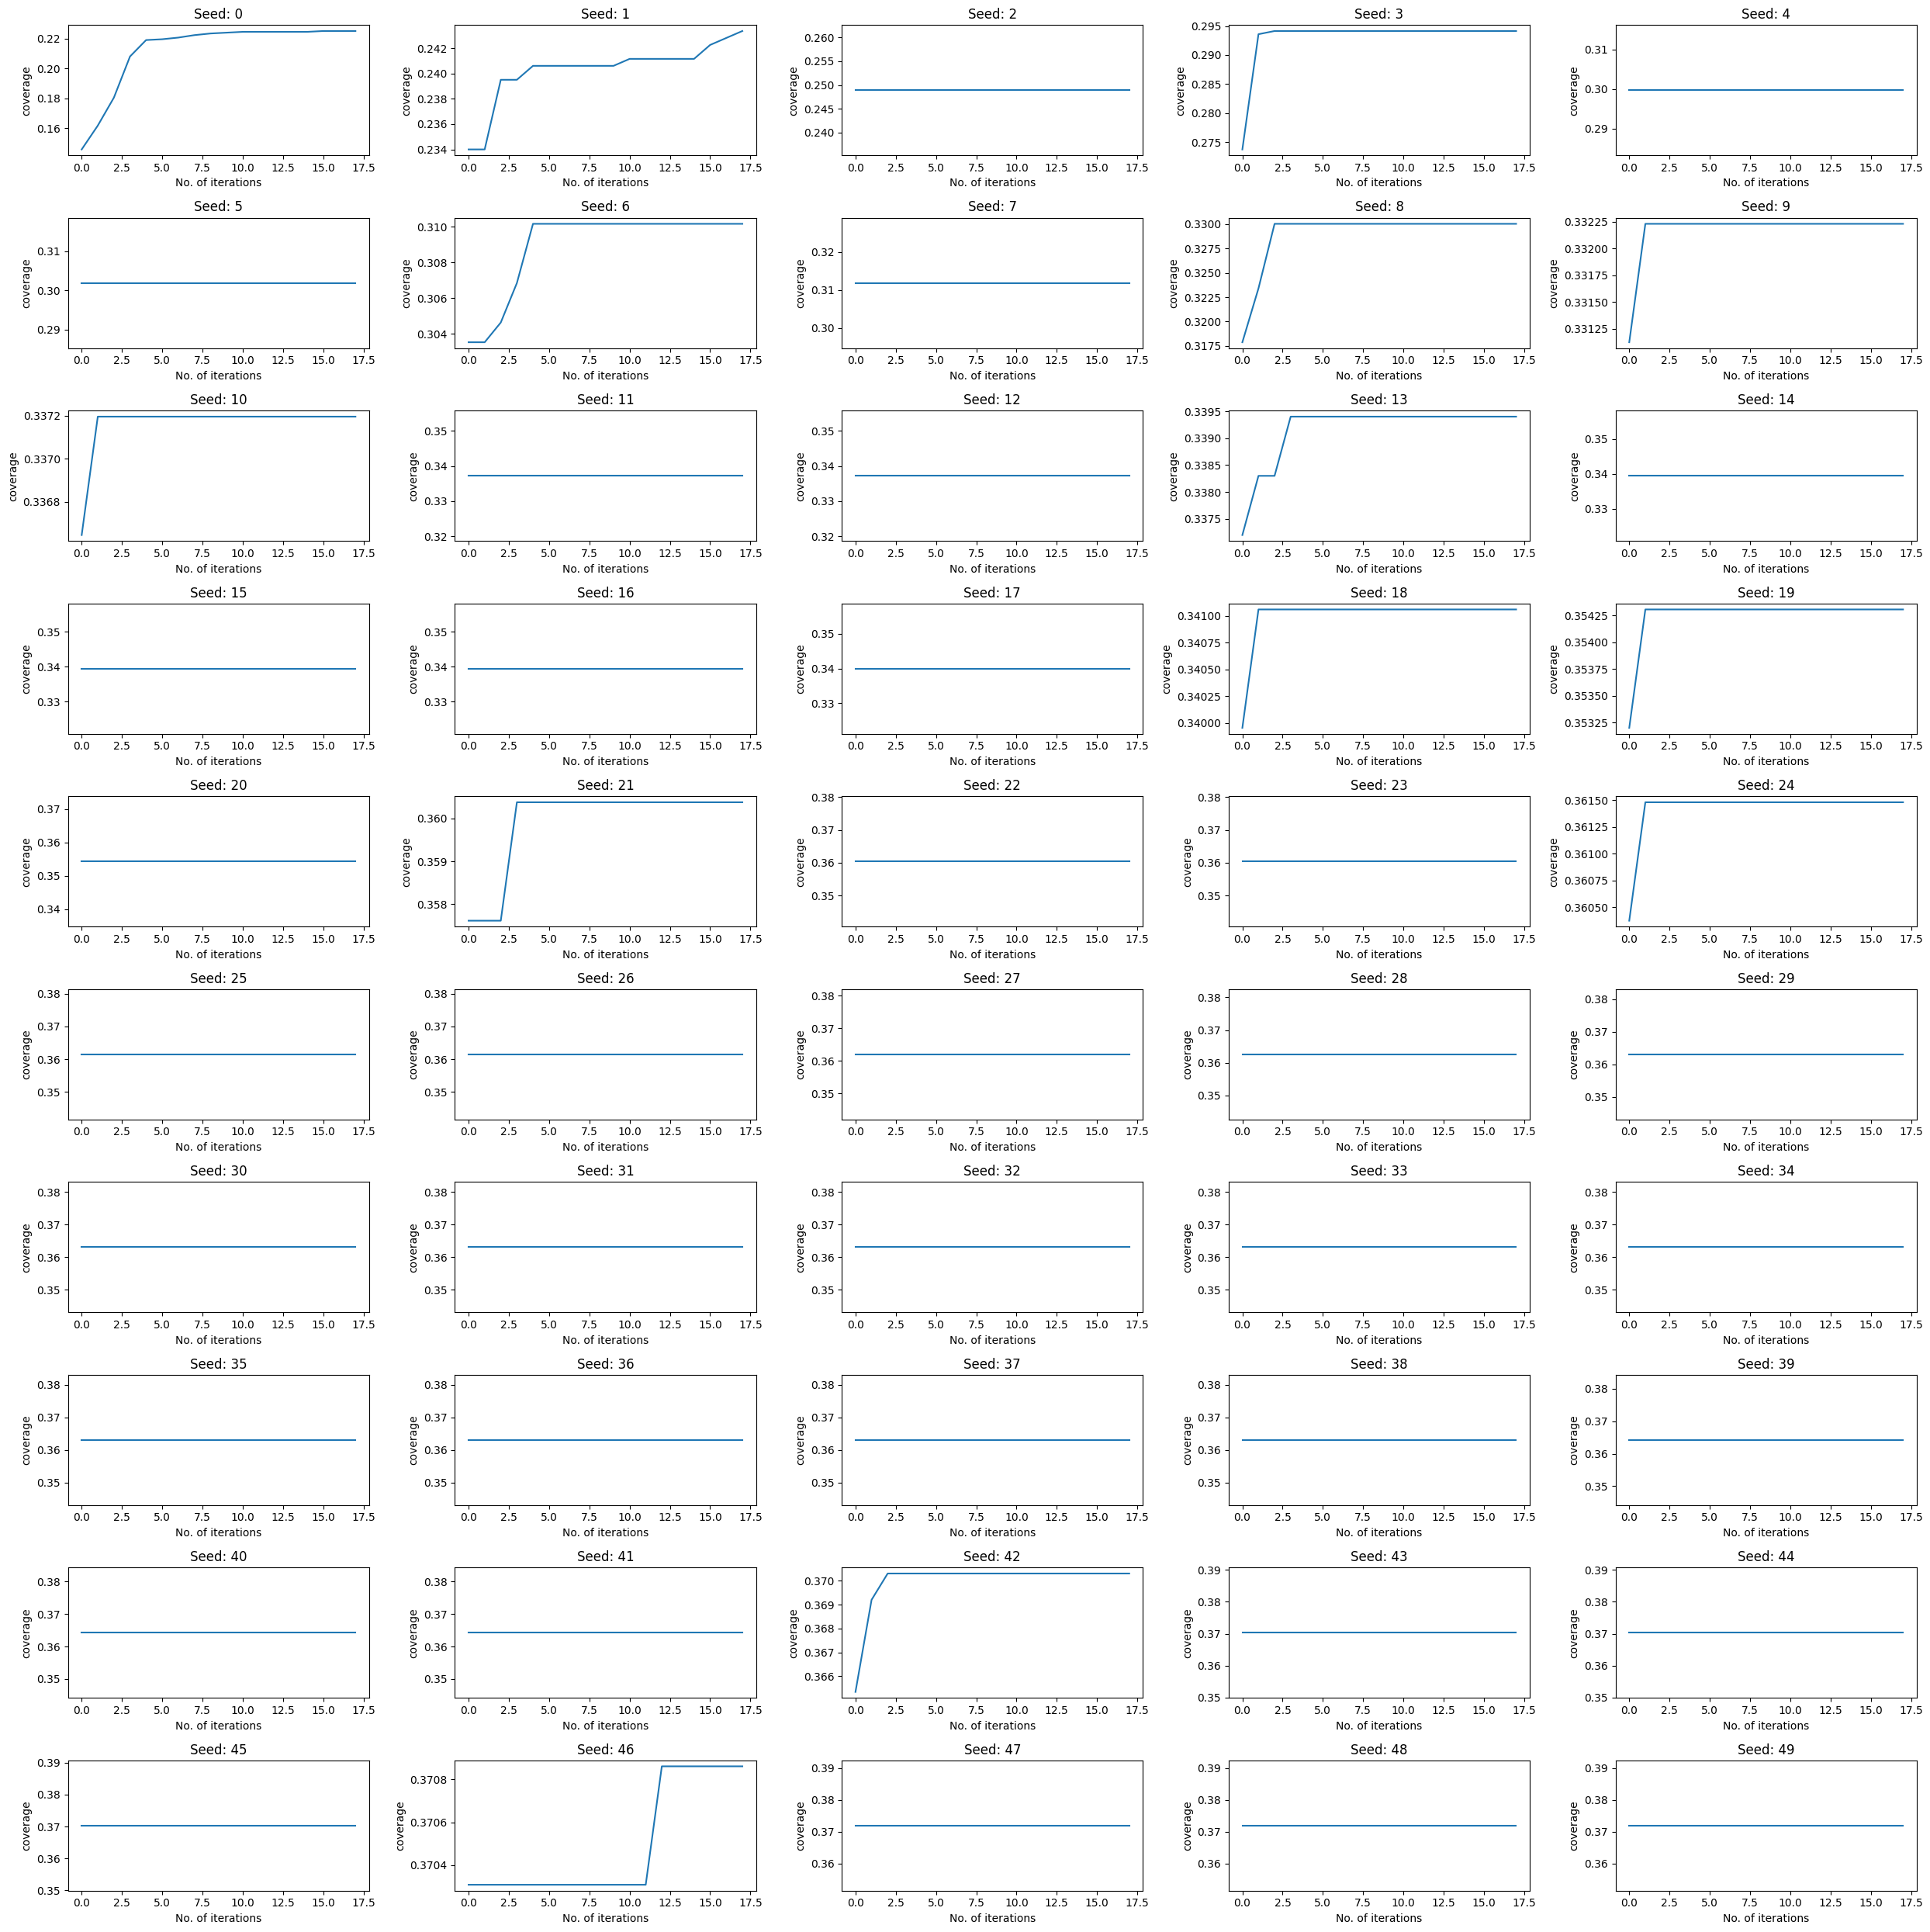

In [23]:
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
for i in range(50):
    axis[i//5, i%5].plot(coverage[i], label = 'coverage')
    #axis[i//5, i%5].set_ylim(0.15, 0.38)
    axis[i//5, i%5].set_xlabel("No. of iterations")
    axis[i//5, i%5].set_ylabel("coverage")
    axis[i//5, i%5].set_title("Seed: " + str(i))
plt.tight_layout()
plt.savefig('./figures/desired18_neuroncov.jpg')

<Figure size 3000x1000 with 0 Axes>

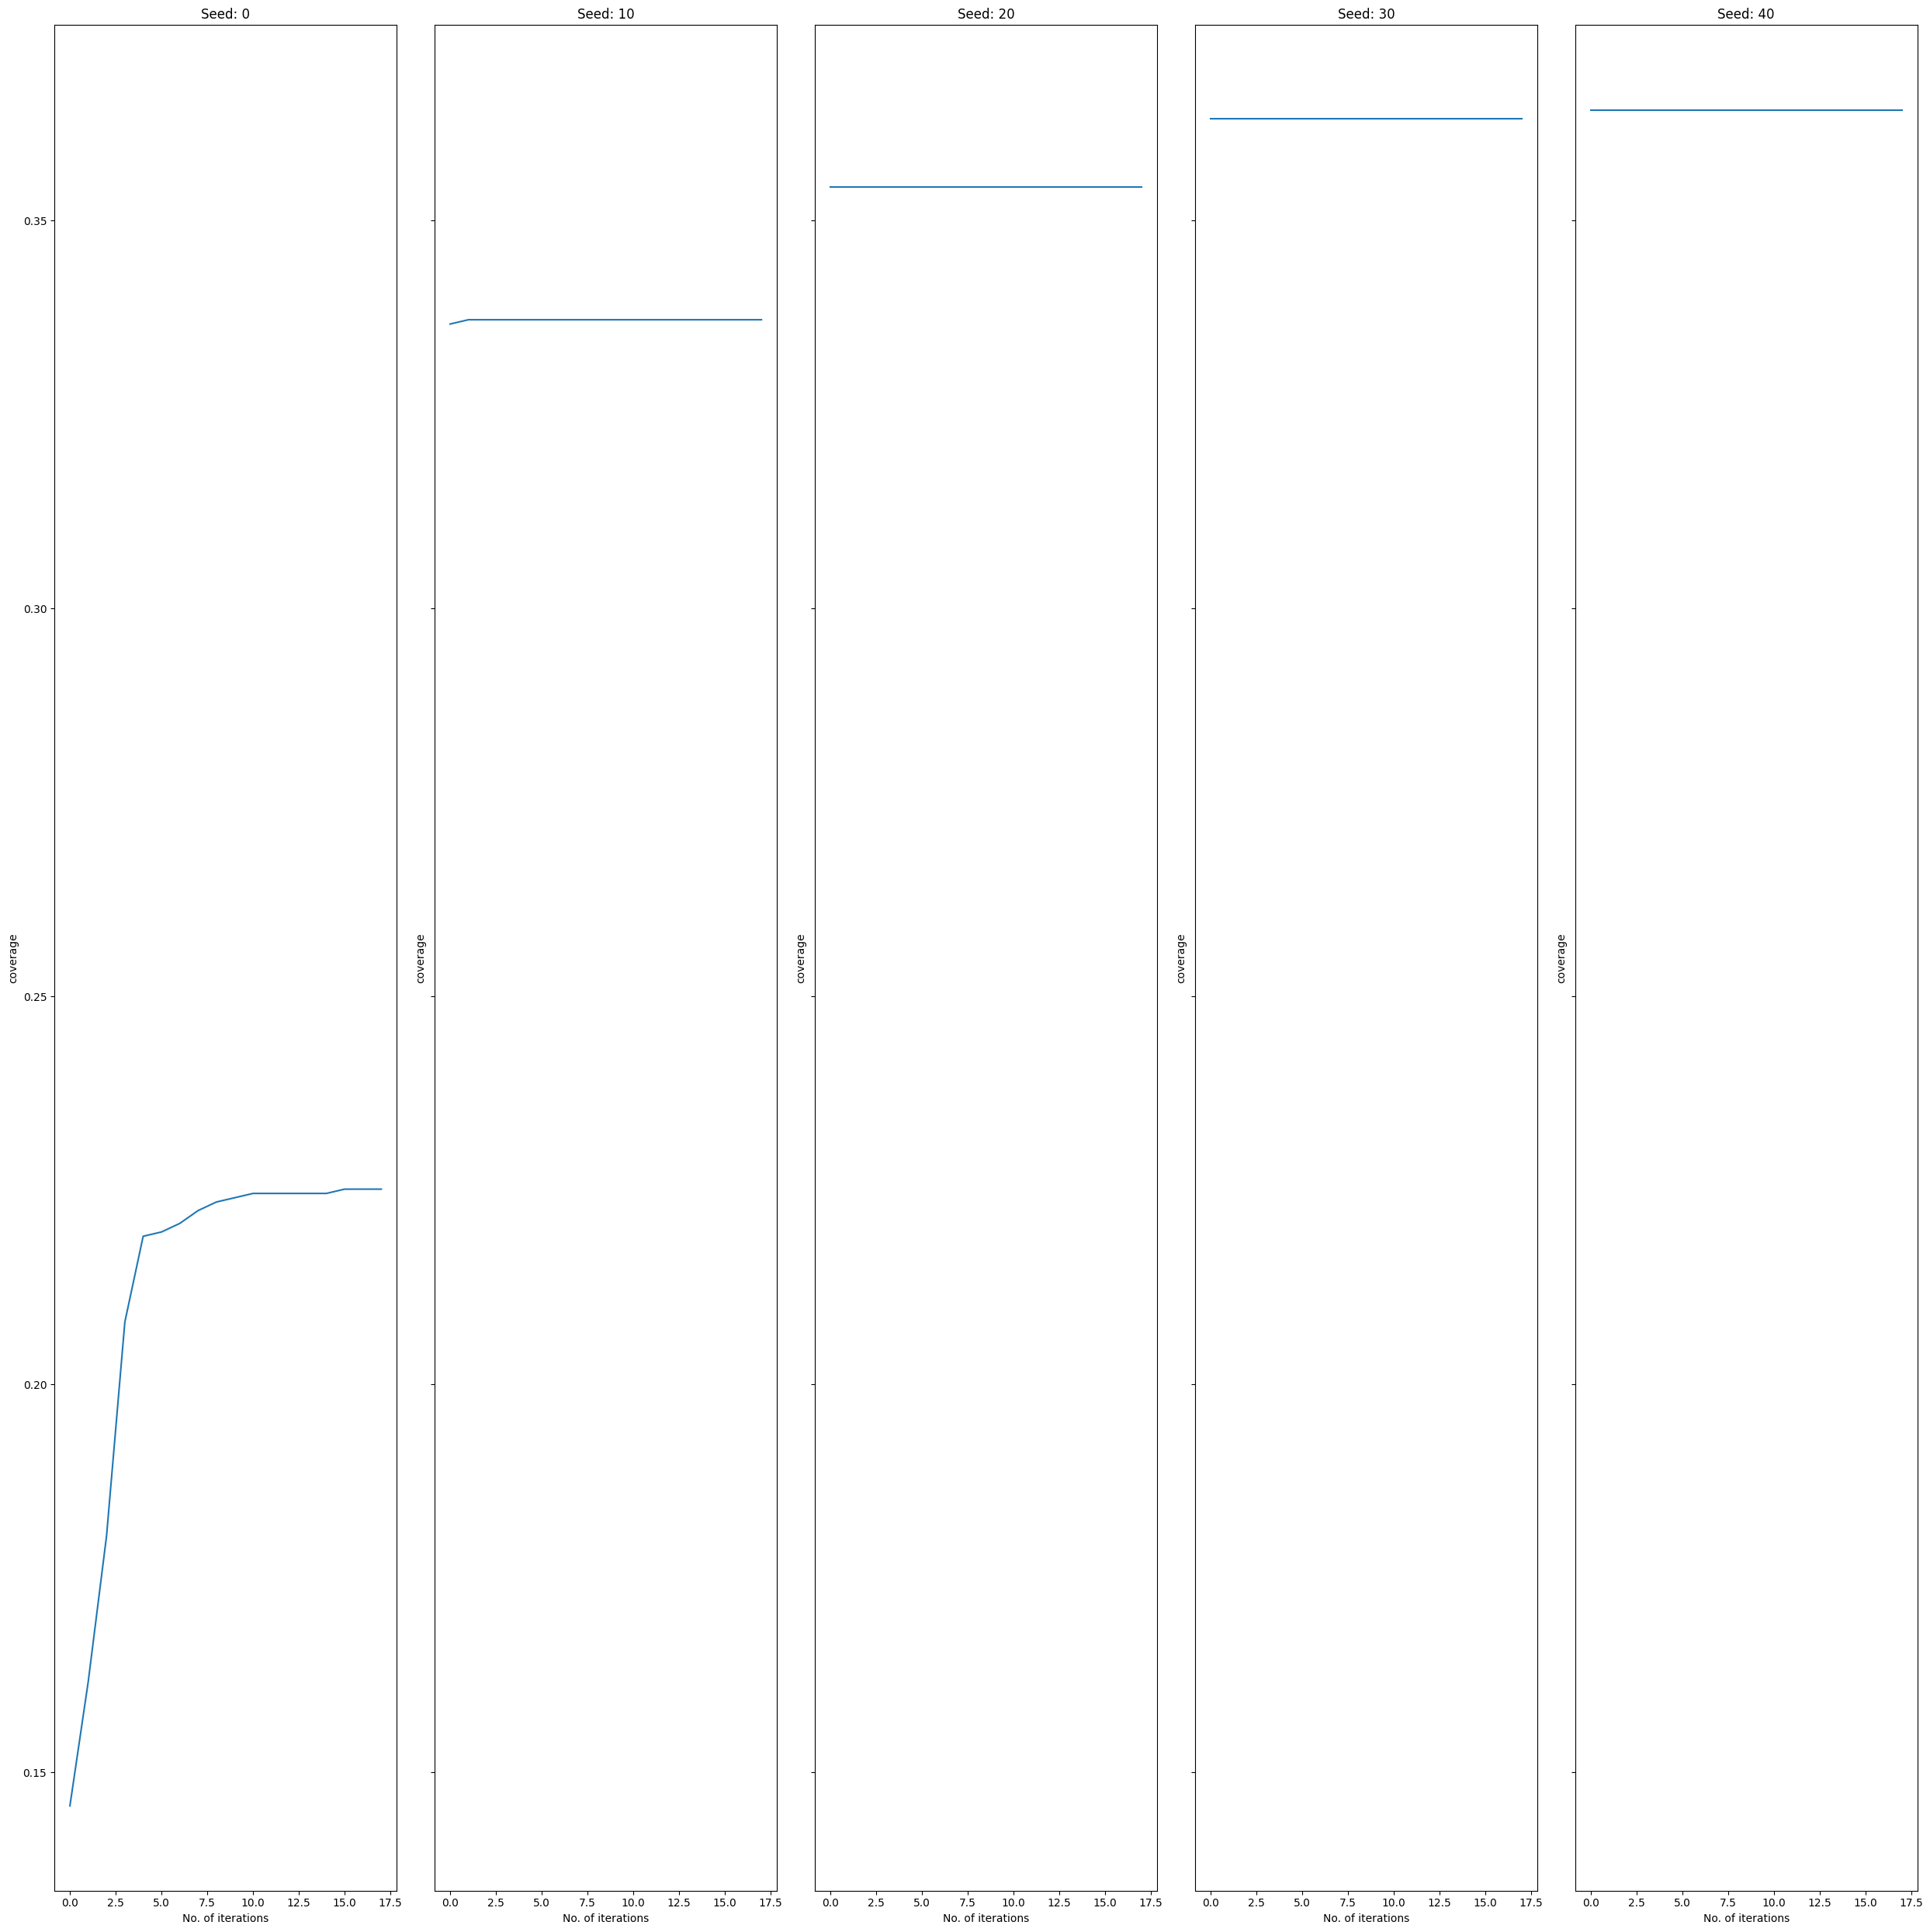

In [27]:
# Graphs for desired coverage (short) only 5 seeds
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(1, 5, sharey=True, figsize = (25,25))
for i in range(5):
    ii = i*10
    axis[i].plot(coverage[ii], label = 'coverage')
    #axis[i//2, i%2].set_ylim(0.15, 0.38)
    axis[i].set_xlabel("No. of iterations")
    axis[i].set_ylabel("coverage")
    axis[i].set_title("Seed: " + str(ii))
plt.tight_layout()
plt.savefig('./figures/desired18_neuroncov_short.jpg')

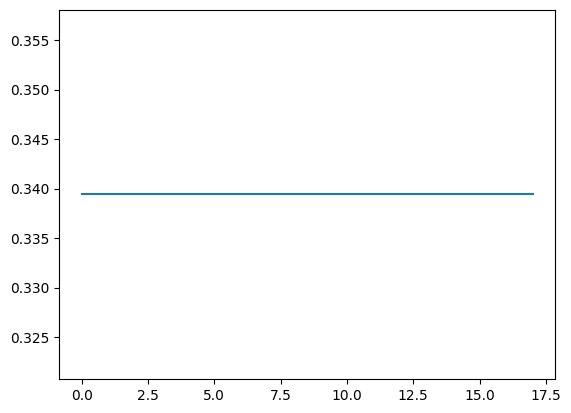

In [20]:
plt.plot(coverage[15], label = 'coverage')

In [17]:
coverage_dl = {}
loss_fn_dl = {}
loss_poison_dict_dl = {}
loss_orig_dict_dl = {}

from __future__ import print_function

from tensorflow.keras.layers import Input
from imageio import imwrite
from utils_tmp import *
import sys
import os
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from Model3 import Model3
from Model3x import Model3x
from Model4 import Model4
from Model4x import Model4x
from Model4x1 import Model4x1
from Model4x2 import Model4x2
import pickle

# input image dimensions
img_rows, img_cols = 32, 32

input_shape = (img_rows, img_cols, 3)
poison_label = 9

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)
# load multiple models sharing same input tensor
K.set_learning_phase(0)

model1 = Model4x2(input_tensor=input_tensor)

print(model1.name)

# model_layer_dict1 = init_coverage_tables(model1)
model_layer_times1 = init_coverage_times(model1)  # times of each neuron covered
model_layer_times2 = init_coverage_times(model1)  # update when new image and adversarial images found
model_layer_value1 = init_coverage_value(model1)
# start gen inputs
# img_paths = image.list_pictures('../seeds_20', ext='JPEG')

img_dir = './seeds_50_poison'
img_paths = os.listdir(img_dir)
img_paths.sort(key = lambda x: int(x.split('_')[0]))
img_num = len(img_paths)

# e.g.[0,1,2] None for neurons not covered, 0 for covered often, 1 for covered rarely, 2 for high weights
neuron_select_strategy = '0'
threshold = 0.5
neuron_to_cover_num = 5
subdir = 'STRIPX15'
iteration_times = 18

neuron_to_cover_weight = 0.5
predict_weight = 0.5
learning_step = 0.02

save_dir = './generated_inputs/' + subdir + '/'
if os.path.exists(save_dir):
    for i in os.listdir(save_dir):
        path_file = os.path.join(save_dir, i)
        if os.path.isfile(path_file):
            os.remove(path_file)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

start = time.process_time()
total_time = 0
total_norm = 0
adversial_num = 0

total_perturb_adversial = 0

for i in range(img_num):

    start_time = time.process_time()

    img_list = []

    img_path = os.path.join(img_dir,img_paths[i])

    img_name = img_paths[i].split('.')[0]

    mannual_label = int(img_name.split('_')[1])

    print(img_path)

    tmp_img = preprocess_image(img_path)

    orig_img = tmp_img.copy()

    img_list.append(tmp_img)

    update_coverage(tmp_img, model1, model_layer_times2, threshold)

    # declaring lists to hold values of coverage and loss values
    loss_fn_list = []
    coverage_list = []
    loss_poison_list = []
    loss_orig_list = []

    while len(img_list) > 0:

        gen_img = img_list[0]

        img_list.remove(gen_img)

        # first check if input already induces differences
        pred1 = model1.predict(gen_img)
        label1 = np.argmax(pred1[0])

        label_top5 = np.argsort(pred1[0])[-5:]

        update_coverage_value(gen_img, model1, model_layer_value1)
        update_coverage(gen_img, model1, model_layer_times1, threshold)

        orig_label = label1
        orig_pred = pred1

        loss_1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss_2 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-2]])
        loss_3 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-3]])
        loss_4 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-4]])
        loss_5 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-5]])

        #changes below: by me
        loss_poison = K.mean(model1.get_layer('before_softmax').output[..., poison_label])
        #layer_output = (predict_weight * (loss_2 + loss_3 + loss_4 + loss_5) - loss_1)
        layer_output = loss_poison - loss_1
        # neuron coverage loss
        loss_neuron = neuron_selection(model1, model_layer_times1, model_layer_value1, neuron_select_strategy,
                                        neuron_to_cover_num, threshold)
        # loss_neuron = neuron_scale(loss_neuron) # useless, and negative result

        # extreme value means the activation value for a neuron can be as high as possible ...
        EXTREME_VALUE = False
        if EXTREME_VALUE:
            neuron_to_cover_weight = 2

        layer_output += neuron_to_cover_weight * K.sum(loss_neuron)

        # for adversarial image generation
        final_loss = K.mean(layer_output)

        # we compute the gradient of the input picture wrt this loss
        grads = normalize(K.gradients(final_loss, input_tensor)[0])

        grads_tensor_list = [loss_1, loss_2, loss_3, loss_4, loss_5, loss_poison]
        grads_tensor_list.extend(loss_neuron)
        grads_tensor_list.append(grads)
        # this function returns the loss and grads given the input picture

        iterate = K.function([input_tensor], grads_tensor_list)

        # we run gradient ascent for 'iteration_times' steps
        for iters in range(iteration_times):

            loss_neuron_list = iterate([gen_img])
            print('loss_neuron_list = ', str(loss_neuron_list[:-1])) #print to see all values of loss values for every label at every iteration

            # loss_fn = loss_neuron_list[5] - loss_neuron_list[0]

            perturb = loss_neuron_list[-1] * learning_step
            
            gen_img += perturb

            # previous accumulated neuron coverage
            previous_coverage = neuron_covered(model_layer_times1)[2]

            pred1 = model1.predict(gen_img)
            label1 = np.argmax(pred1[0])

            update_coverage(gen_img, model1, model_layer_times1, threshold) # for seed selection

            current_coverage = neuron_covered(model_layer_times1)[2]

            diff_img = gen_img - orig_img

            L2_norm = np.linalg.norm(diff_img)

            orig_L2_norm = np.linalg.norm(orig_img)

            perturb_adversial = L2_norm / orig_L2_norm

            #changes below by me
            print('perturbation % = ', str(perturb_adversial))
            #Recording values of neuron coverage, loss fn values in lists. Used for creating graphs later.
            coverage_list.append(current_coverage)
            loss_fn_list.append(loss_neuron_list[5] - loss_neuron_list[0])
            loss_poison_list.append(loss_neuron_list[5])
            loss_orig_list.append(loss_neuron_list[0])
            
            if current_coverage - previous_coverage > 0.01 / (i + 1) and perturb_adversial < 0.06:
                img_list.append(gen_img)
                # print('coverage diff = ', current_coverage - previous_coverage, 'perturb_adversial = ', perturb_adversial)

            if (iters == iteration_times-1) & (len(img_list)==0):
                coverage_dl[i] = coverage_list
                loss_fn_dl[i] = loss_fn_list
                loss_poison_dict_dl[i] = loss_poison_list
                loss_orig_dict_dl[i] = loss_orig_list
            
            if label1 != orig_label:
                update_coverage(gen_img, model1, model_layer_times2, threshold)

                total_norm += L2_norm

                total_perturb_adversial += perturb_adversial

                # print('L2 norm : ' + str(L2_norm))
                # print('ratio perturb = ', perturb_adversial)

                gen_img_tmp = gen_img.copy()

                gen_img_deprocessed = deprocess_image(gen_img_tmp)

                save_img = save_dir + img_name + '_' + str(orig_label) + '_'  + str(label1) + '_' + str(get_signature()) + '.png'

                imwrite(save_img, gen_img_deprocessed)

                adversial_num += 1

    end_time = time.process_time()

    print('covered neurons percentage %d neurons %.3f'
            % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))

    duration = end_time - start_time

    print('used time : ' + str(duration))

    total_time += duration

print('covered neurons percentage %d neurons %.3f'
      % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))

print('total_time = ' + str(total_time))
print('average_norm = ' + str(total_norm / adversial_num))
print('adversial num = ' + str(adversial_num))
print('average perb adversial = ' + str(total_perturb_adversial / adversial_num))
file_descriptor = open('analysis_files/loss_fn_dl.pkl', 'wb')
pickle.dump(loss_fn_dl, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/coverage_dl.pkl', 'wb')
pickle.dump(coverage_dl, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_poison_dict_dl.pkl', 'wb')
pickle.dump(loss_poison_dict_dl, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_orig_dict_dl.pkl', 'wb')
pickle.dump(loss_orig_dict_dl, file_descriptor)
file_descriptor.close()

/usr/local/lib/python3.9/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                          

/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


loss_neuron_list =  [11.178358, 2.2137644, 1.6509615, 1.1585121, 0.5649761, -1.1796423, -4.9570017, -5.070559, -8.695543, 1.3886547, 0.77901375]
perturbation % =  0.04405256
loss_neuron_list =  [15.375874, 19.487154, 15.475377, 16.107069, 17.492647, 22.664589, -5.925291, -5.7805524, -10.306187, 1.949538, 1.3040397]
perturbation % =  0.0628526
loss_neuron_list =  [-25.710886, -16.351437, -24.056063, -22.96429, -19.761858, 0.25280258, -6.2740865, -6.366688, -10.924775, 4.823175, 3.4147296]
perturbation % =  0.08069896
loss_neuron_list =  [-67.79875, -57.418446, -65.47459, -63.6548, -57.760494, -22.817299, -7.3241396, -7.153439, -11.327411, 7.3377285, 5.1990232]
perturbation % =  0.09956841
loss_neuron_list =  [-119.21704, -106.42204, -118.36744, -111.638565, -105.84283, -54.968662, -6.611224, -8.206362, -11.794389, 11.488614, 7.0646553]
perturbation % =  0.11623404
loss_neuron_list =  [-170.13167, -156.53947, -168.53902, -160.42719, -153.8625, -85.84258, -7.5280924, -9.108154, -12.386225

In [28]:
import pickle
file_descriptor = open('analysis_files/loss_fn_dl.pkl', 'rb')
loss_fn_dl = pickle.load(file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/coverage_dl.pkl', 'rb')
coverage_dl = pickle.load(file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_poison_dict_dl.pkl', 'rb')
loss_poison_dict_dl = pickle.load(file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_orig_dict_dl.pkl', 'rb')
loss_orig_dict_dl = pickle.load(file_descriptor)
file_descriptor.close()

<Figure size 3000x1000 with 0 Axes>

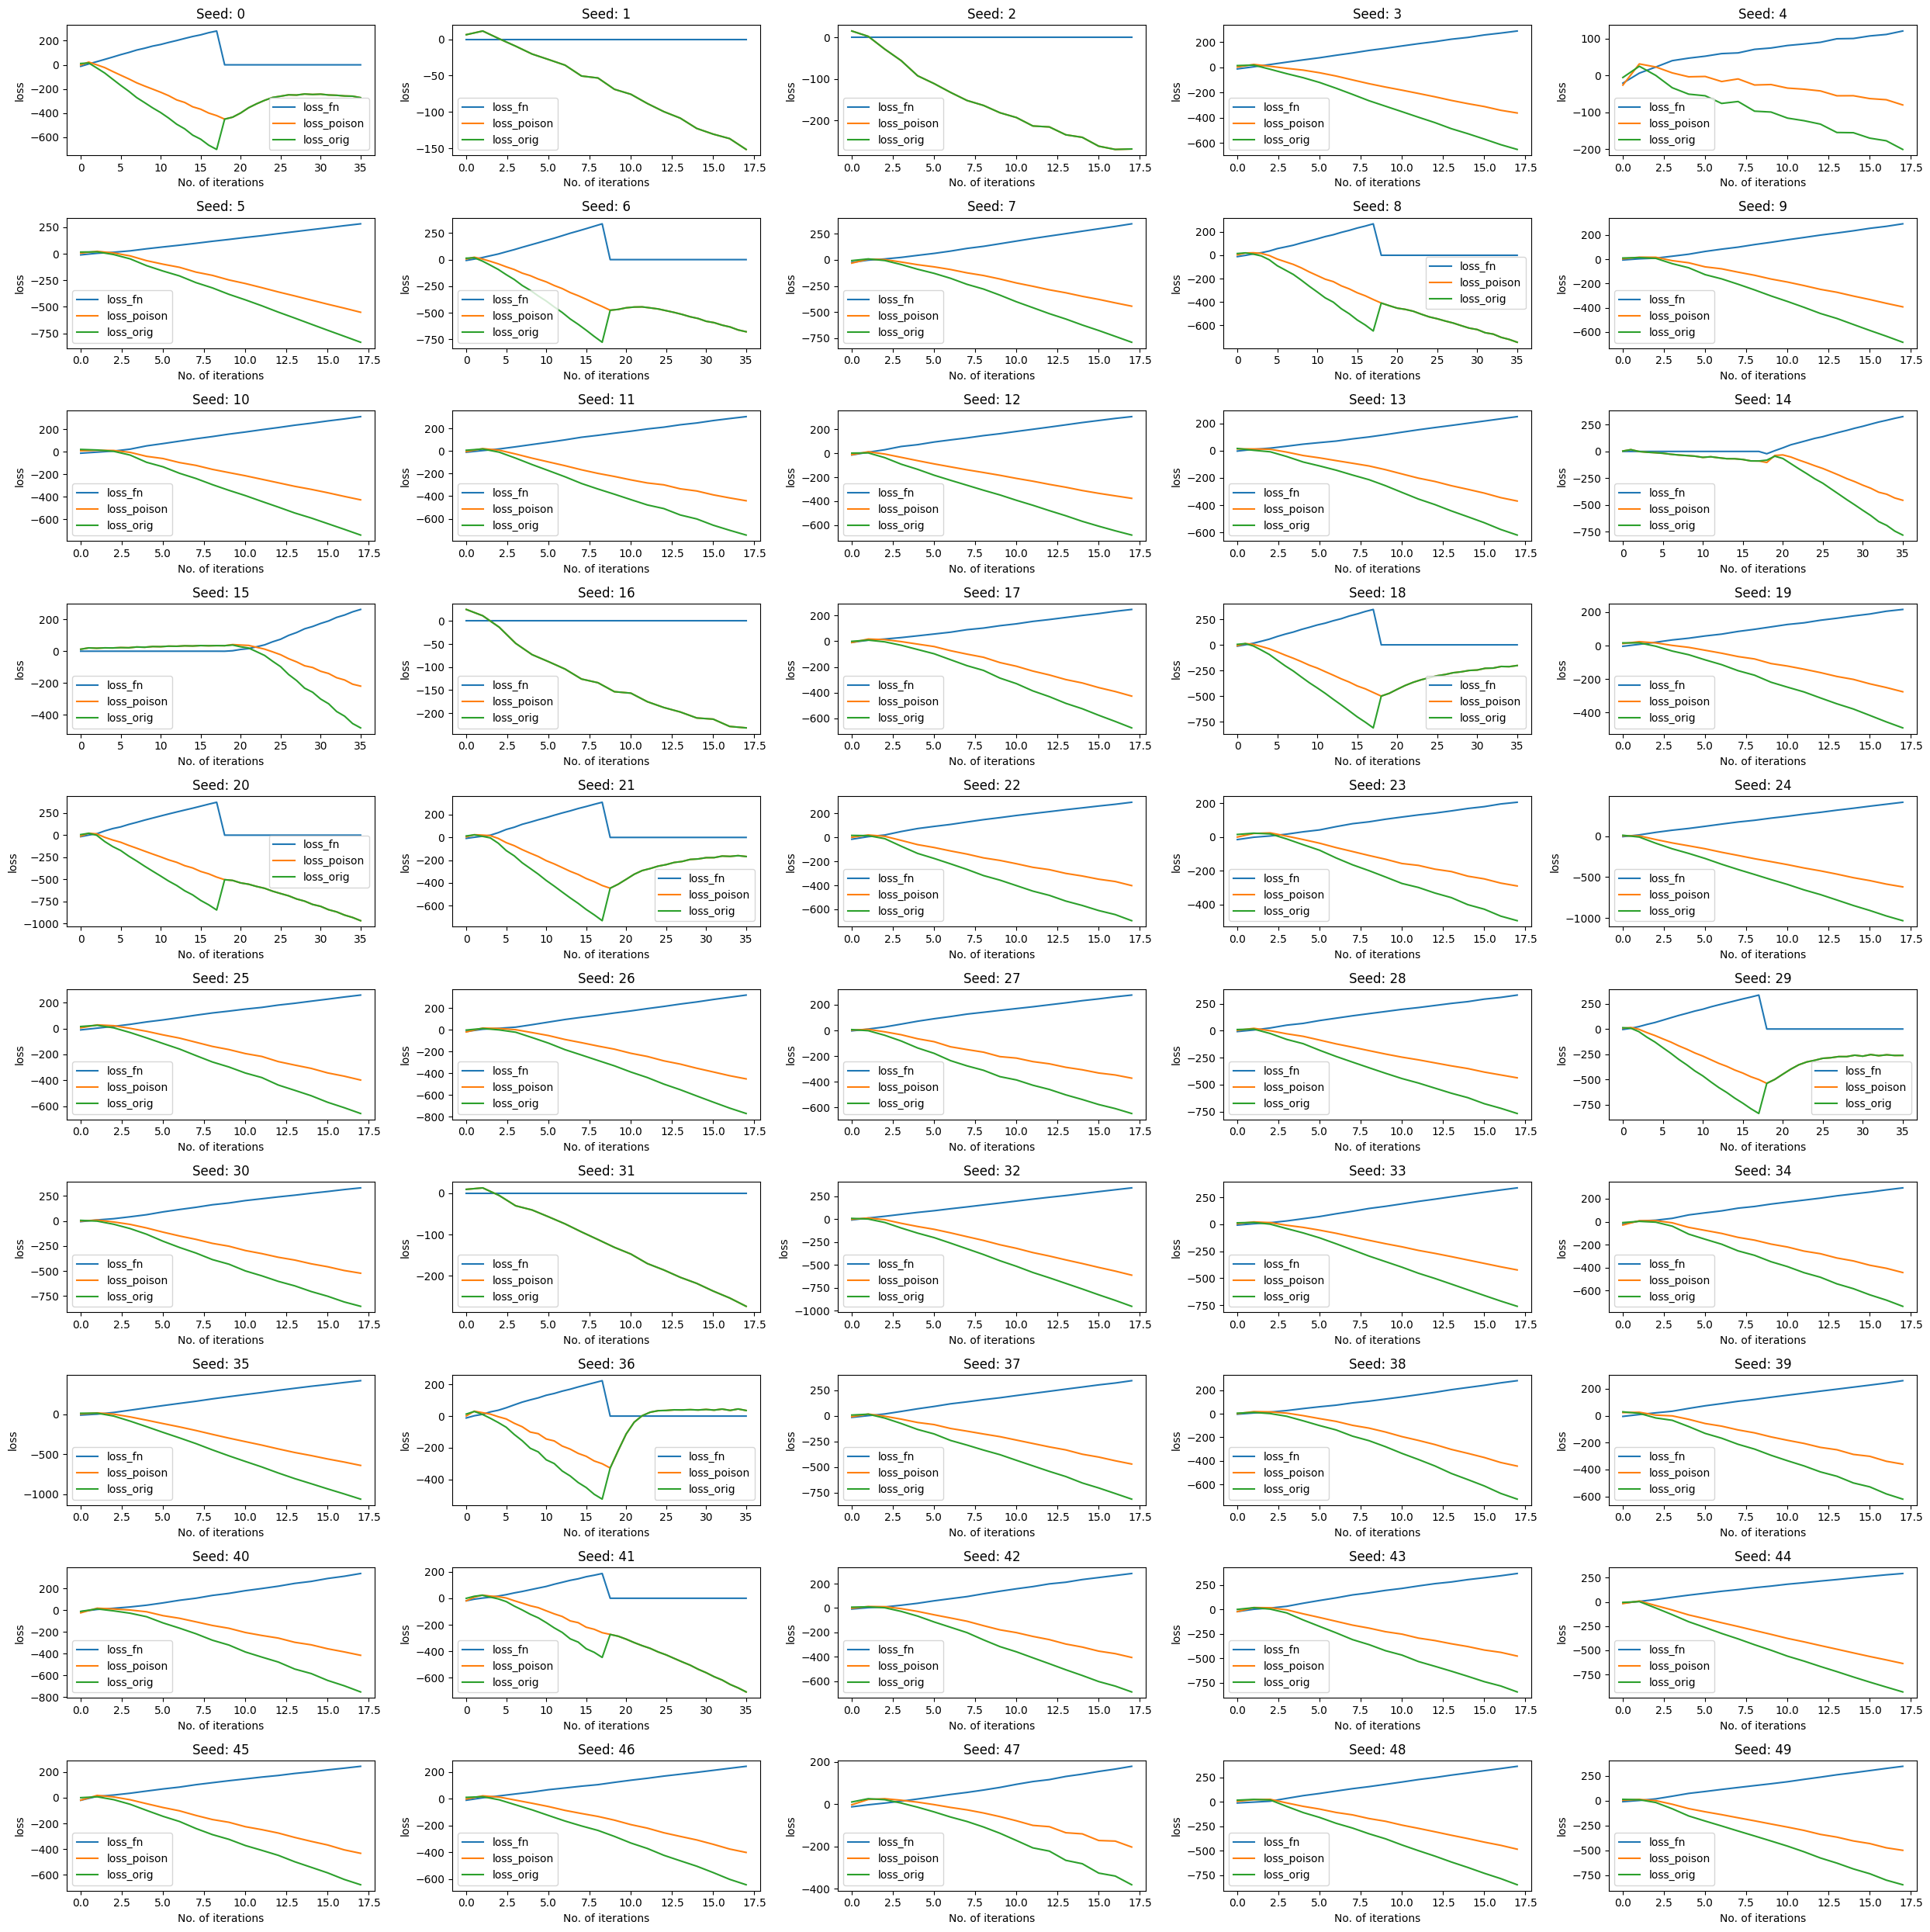

In [29]:
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
j = 0
for i in range(50):
    axis[i//5, i%5].plot(loss_fn_dl[i], label = 'loss_fn')
    axis[i//5, i%5].plot(loss_poison_dict_dl[i], label = 'loss_poison')
    axis[i//5, i%5].plot(loss_orig_dict_dl[i], label = 'loss_orig')
    axis[i//5, i%5].set_xlabel("No. of iterations")
    axis[i//5, i%5].set_ylabel("loss")
    axis[i//5, i%5].set_title("Seed: " + str(i))
    axis[i//5, i%5].legend()
plt.tight_layout()
plt.savefig('./figures/stripx15_l2.jpg')

<Figure size 3000x1000 with 0 Axes>

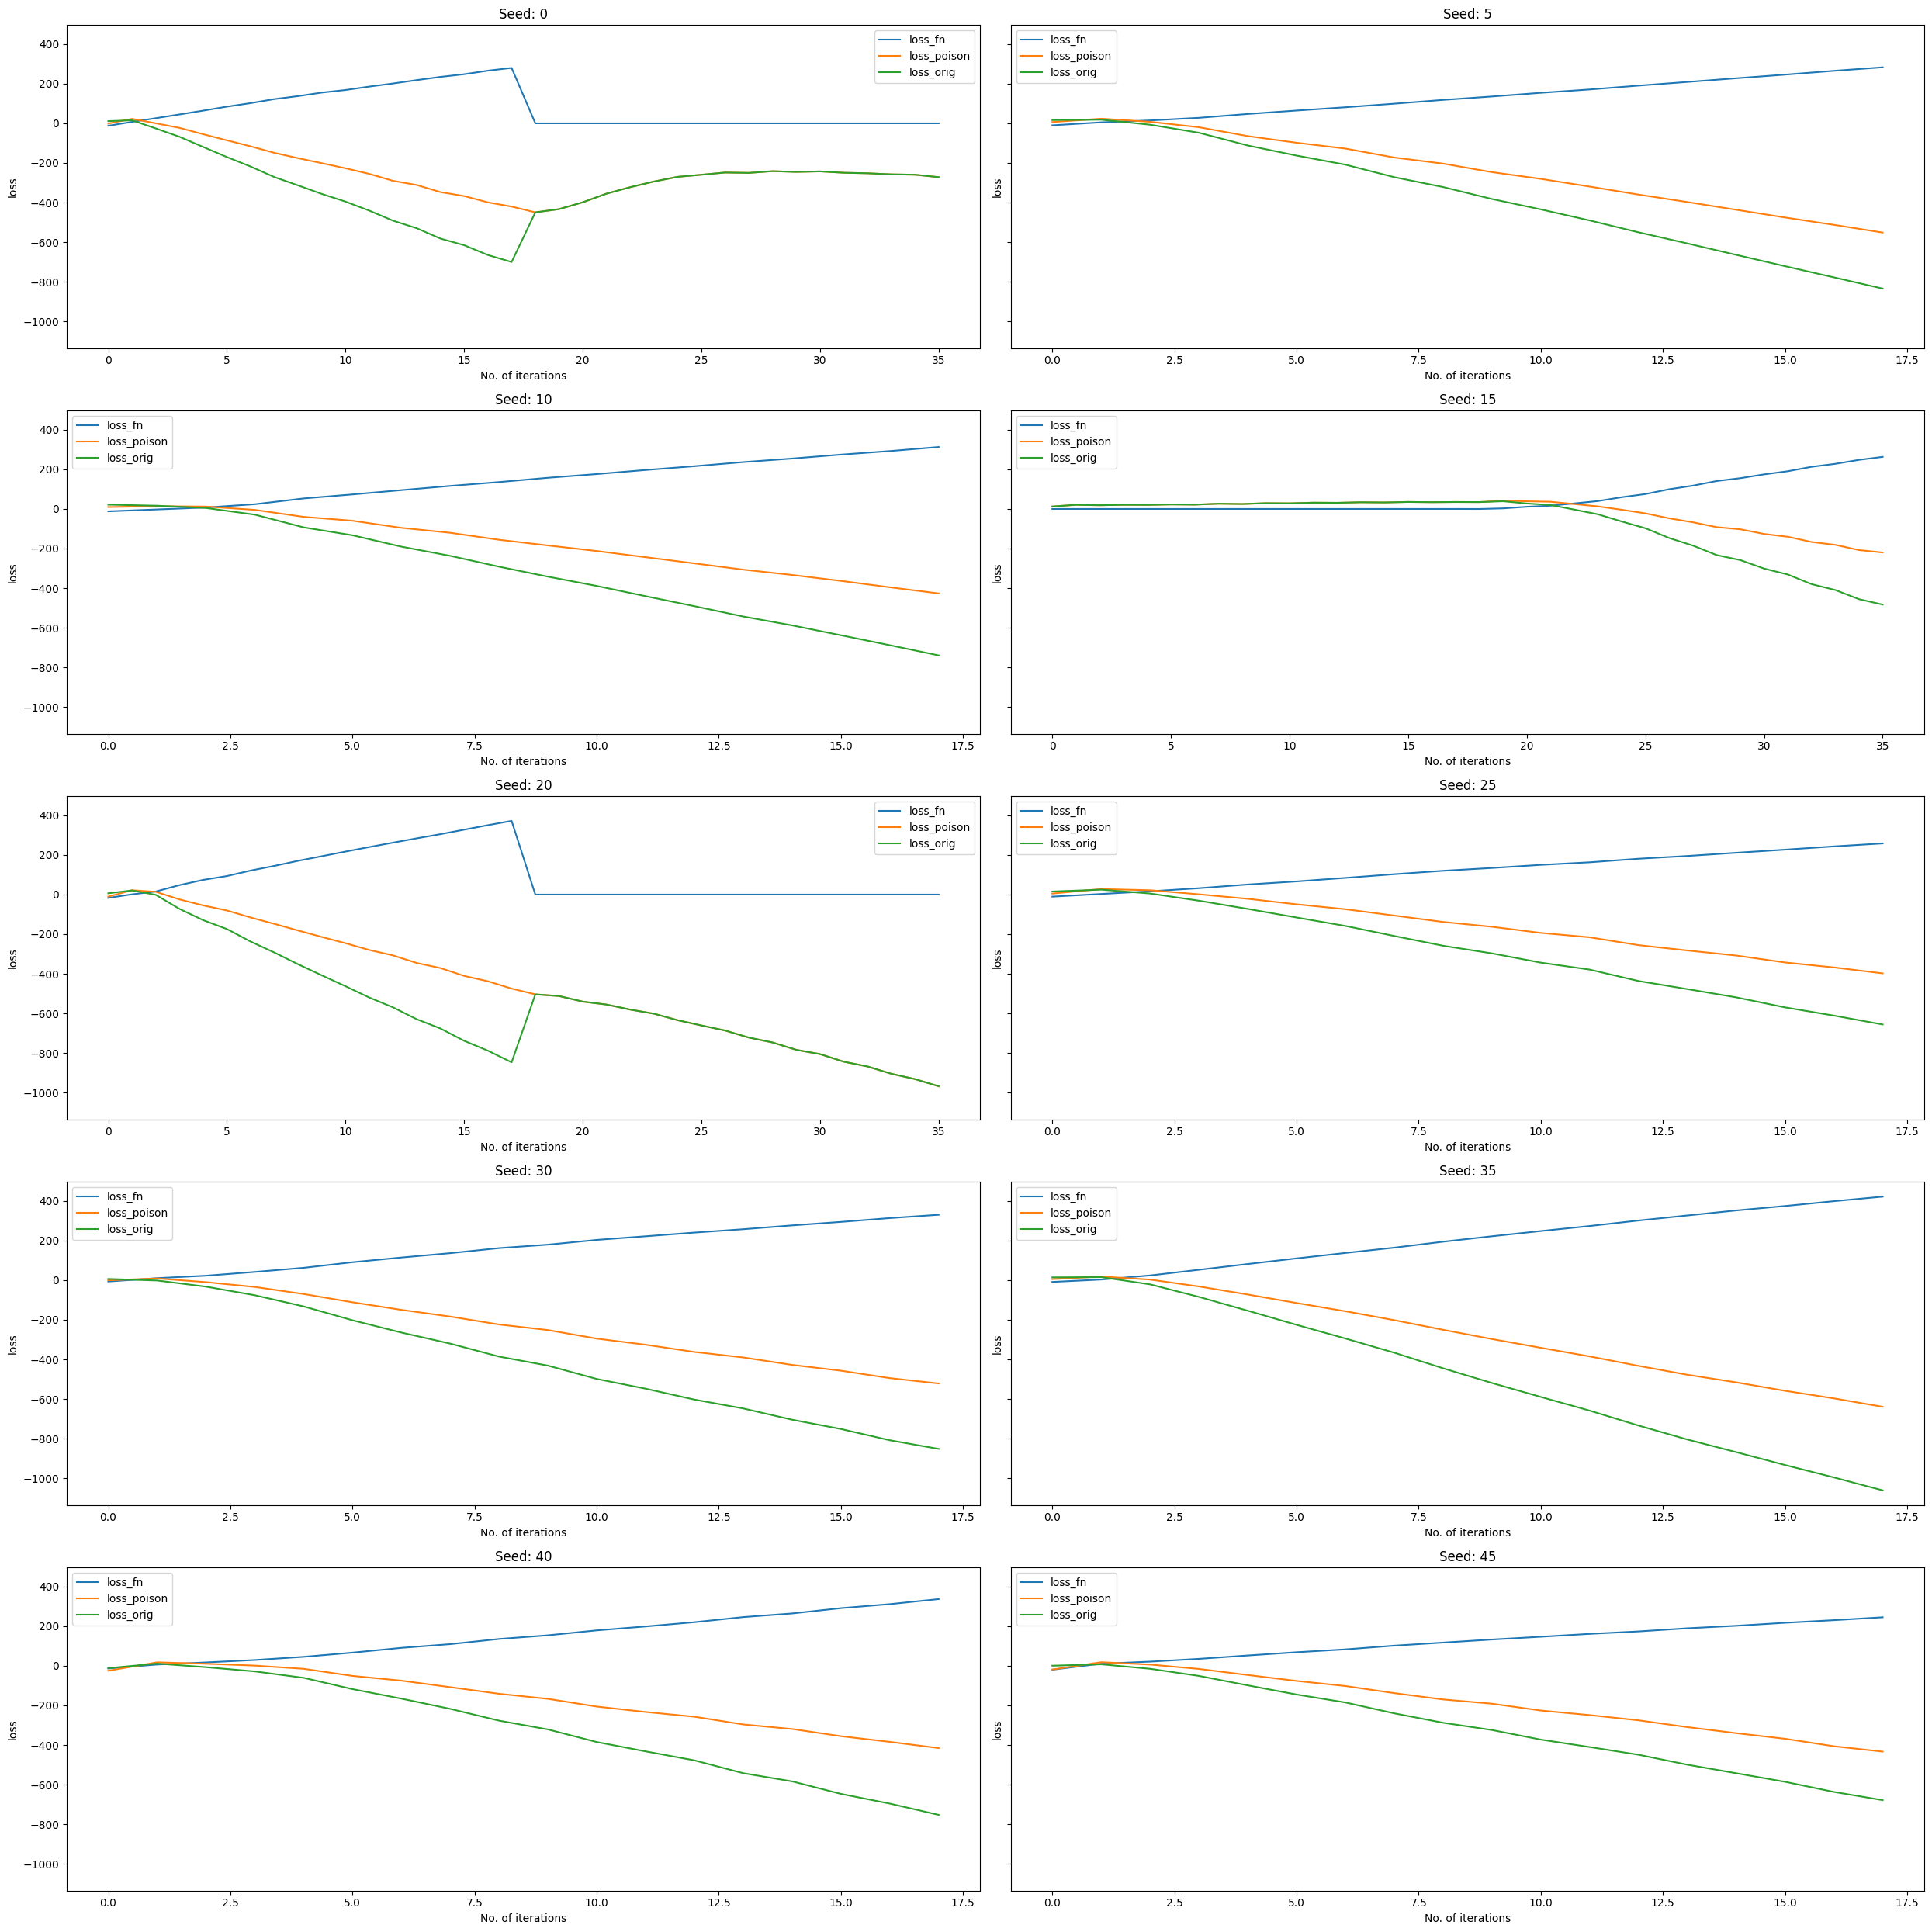

In [30]:
# Graphs for dl model STRIPX15 l2 (short) only 10 seeds
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(5, 2, sharey=True, figsize = (25,25))
for i in range(10):
    ii = i*5
    axis[i//2, i%2].plot(loss_fn_dl[ii], label = 'loss_fn')
    axis[i//2, i%2].plot(loss_poison_dict_dl[ii], label = 'loss_poison')
    axis[i//2, i%2].plot(loss_orig_dict_dl[ii], label = 'loss_orig')
    #axis[i//2, i%2].set_ylim(-130, 75)
    axis[i//2, i%2].set_xlabel("No. of iterations")
    axis[i//2, i%2].set_ylabel("loss")
    axis[i//2, i%2].set_title("Seed: " + str(ii))
    axis[i//2, i%2].legend()
plt.tight_layout()
plt.savefig('./figures/stripx15_l2_short.jpg')

<Figure size 3000x1000 with 0 Axes>

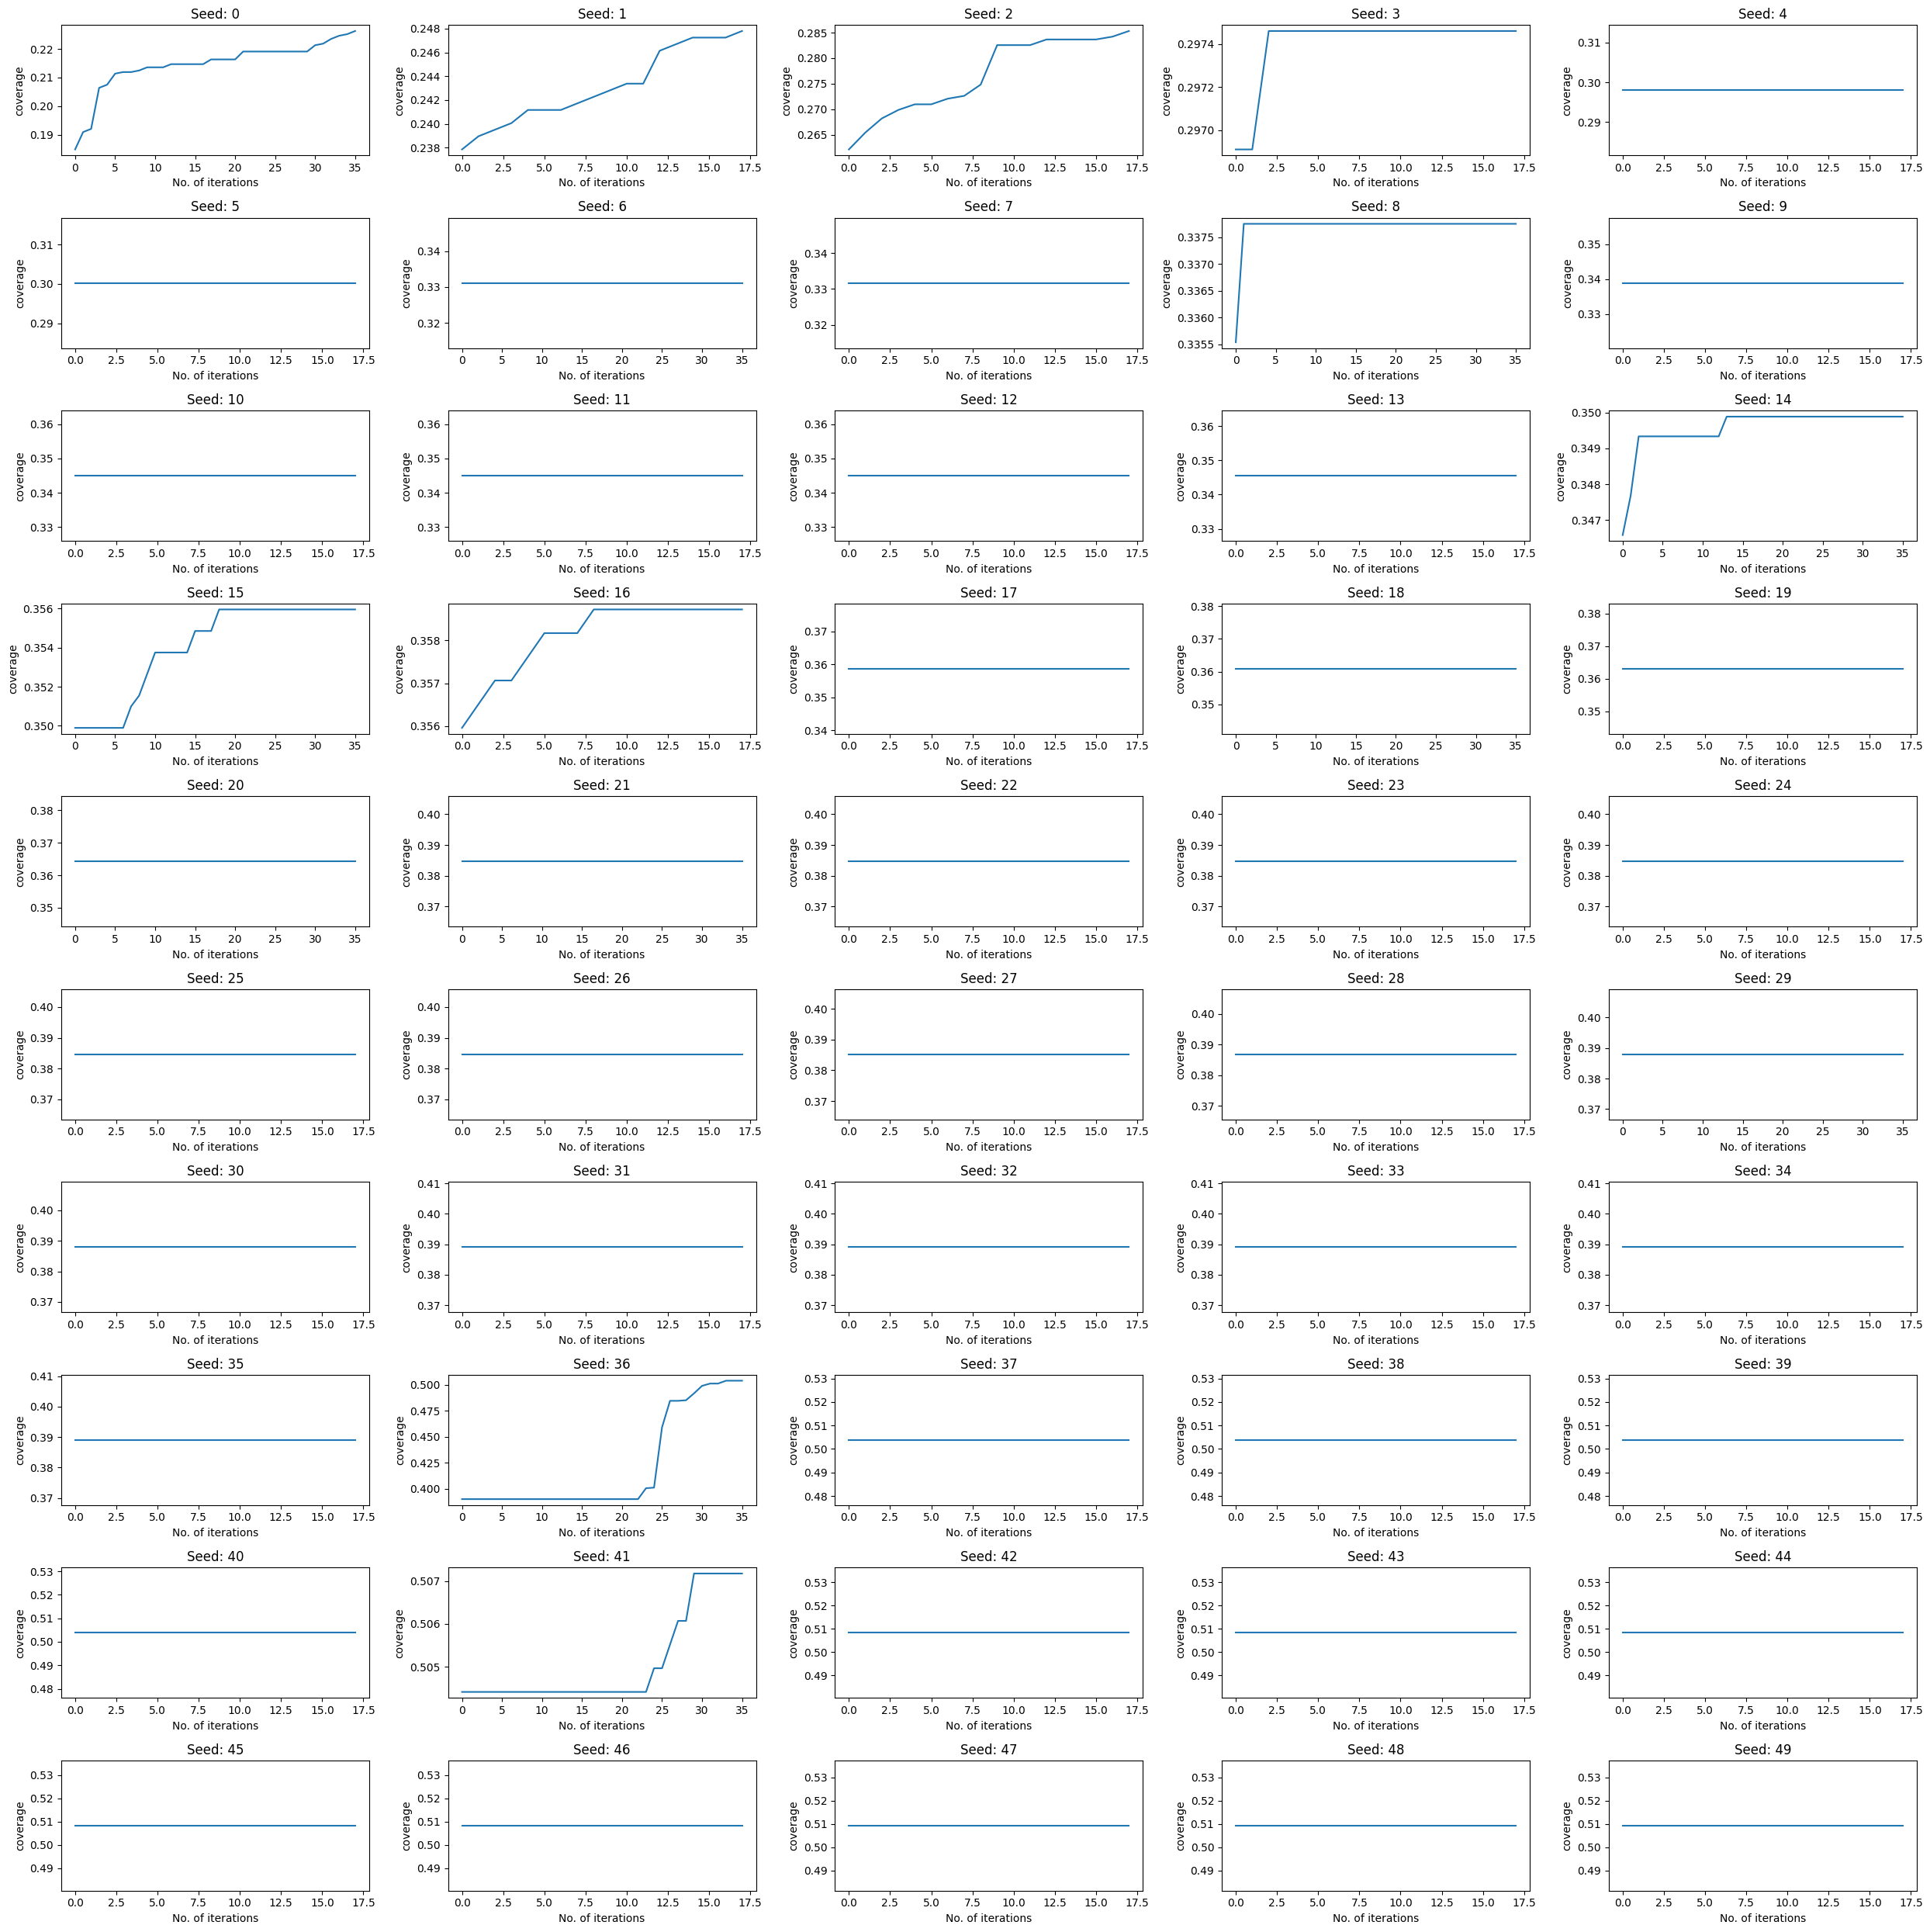

In [18]:
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
j=0
for i in range(50):
    axis[i//5, i%5].plot(coverage_dl[i], label = 'coverage')
    axis[i//5, i%5].set_xlabel("No. of iterations")
    axis[i//5, i%5].set_ylabel("coverage")
    axis[i//5, i%5].set_title("Seed: " + str(i))
plt.tight_layout()
plt.savefig('./figures/stripx15_neuroncov.jpg')

<Figure size 3000x1000 with 0 Axes>

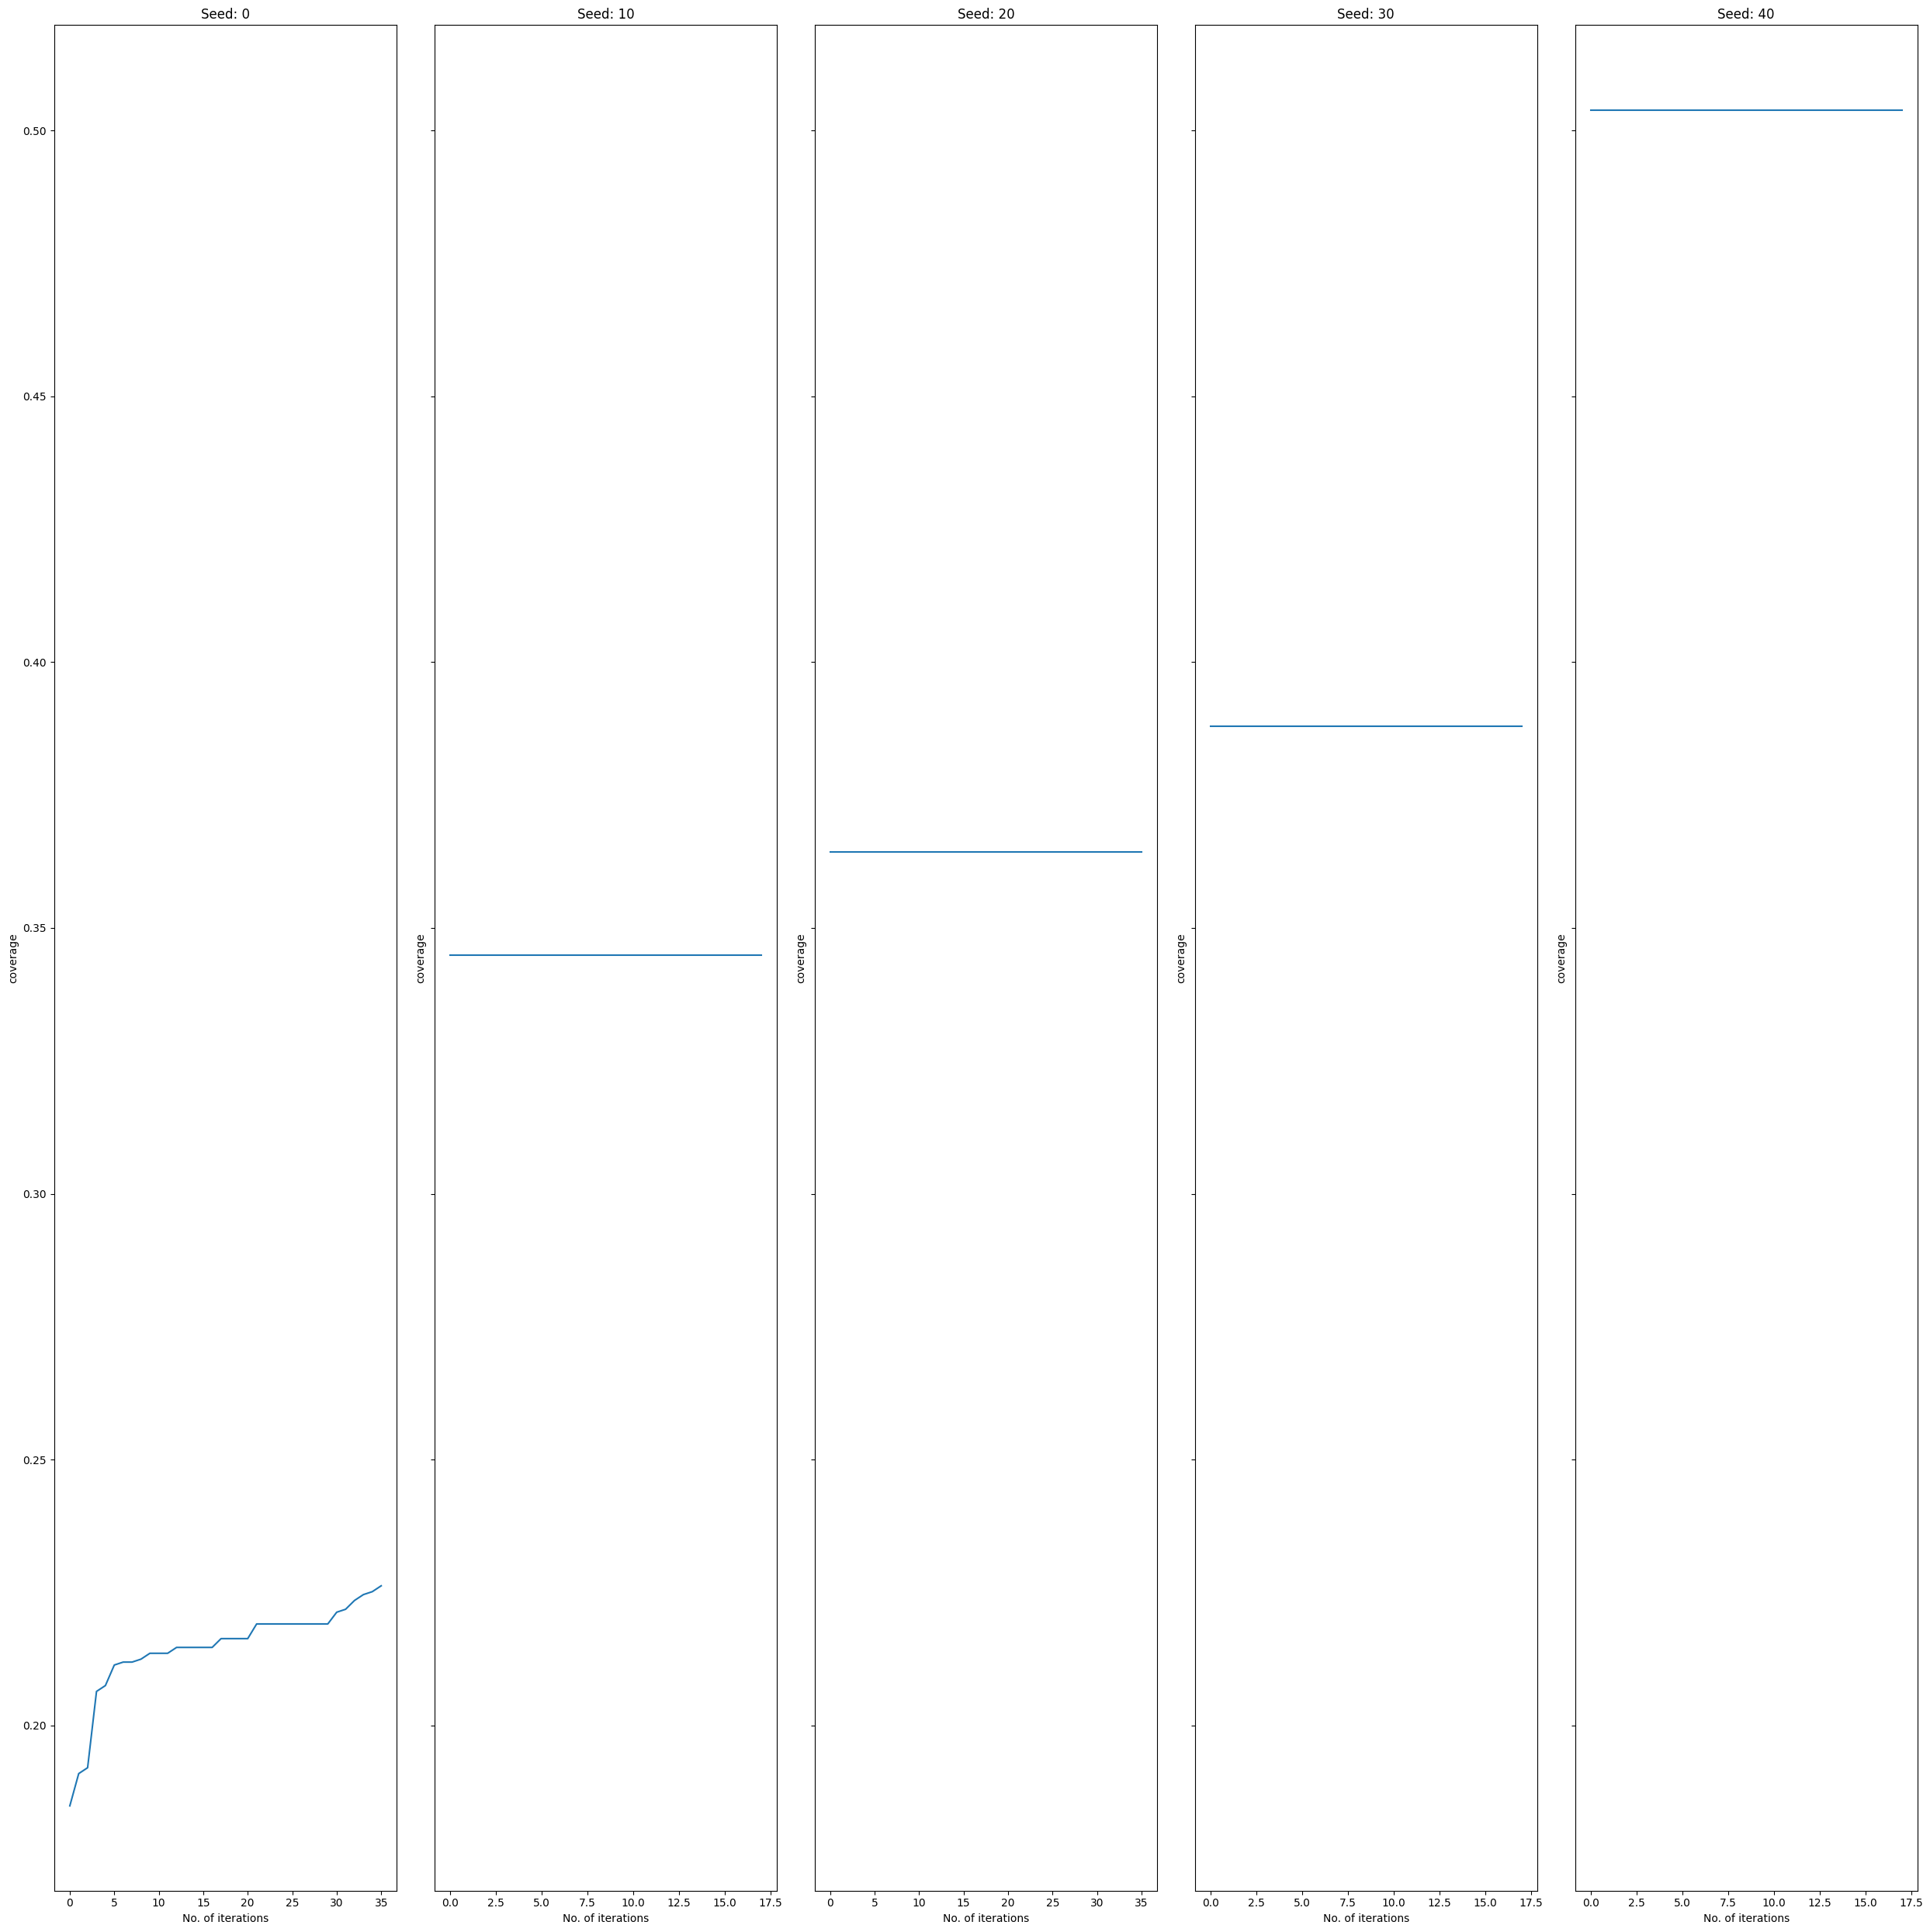

In [31]:
# Graphs for dl model STRIPX15 coverage (short) only 5 seeds
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(1, 5, sharey=True, figsize = (25,25))
for i in range(5):
    ii = i*10
    axis[i].plot(coverage_dl[ii], label = 'coverage')
    #axis[i//2, i%2].set_ylim(0.15, 0.38)
    axis[i].set_xlabel("No. of iterations")
    axis[i].set_ylabel("coverage")
    axis[i].set_title("Seed: " + str(ii))
plt.tight_layout()
plt.savefig('./figures/stripx15_neuroncov_short.jpg')